<a href="https://colab.research.google.com/github/calebbuffa/Spatial-Prediction-of-European-Terrorism/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning

## Set Enviroment

First, mount Google Drive.

In [ ]:
# Set directory path
import os
os.chdir('/content/drive/MyDrive/Thesis')
root_dir = '/content/drive/MyDrive/Thesis'

In [ ]:
# Uninstall sklearn to get version 0.24
%%capture
!pip uninstall scikit-learn -y

In [ ]:
# Install necessary libaries
%%capture
!pip install pandas fiona shapely pyproj rtree
!pip install descartes
!pip install -U scikit-learn
!pip install geopandas
!pip install esda
!pip install libpysal as lp

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, learning_curve, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.utils.class_weight import compute_class_weight
import sklearn
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance
import geopandas
import esda
import libpysal as lp
from sklearn.cluster import DBSCAN
import warnings

warnings.filterwarnings('ignore')

#%matplotlib inline
#sns.color_palette('flare', as_cmap=True)
#plt.style.use('seaborn-bright')
pd.options.mode.use_inf_as_na=True

np.random.seed(1)

In [ ]:
print(sklearn.__version__)

0.24.2


## Read in and prepare data

In [ ]:
# Read in data
orig_data = pd.read_csv('Data/training_data.csv', index_col=False)

In [ ]:
orig_data.columns

Index(['OID_', 'GRID_ID', 'ORIG_FID', 'Attack', 'eventid', 'iyear', 'imonth',
       'iday', 'approxdate', 'extended',
       ...
       'elevation', 'impervious_land', 'dist_maj_waterway', 'pop_density',
       'landcover', 'slope', 'built_settlement_growth', 'dist_inland_water',
       'dist_majroad', 'dist_majroad_int'],
      dtype='object', length=156)

In [ ]:
data = orig_data[["OID_", "POINT_X", "POINT_Y", "Attack", "built_settlement_growth", "landcover", 'gdp',
             "dist_inland_water", "dist_majroad", "dist_majroad_int", "dist_maj_waterway", 'impervious_land',
             "elevation", "civil_unrest","f_15_49", "pop_density", "slope", "nighttime_lights", "pop_count"]]

In [ ]:
data['civil_unrest'] = data['civil_unrest'].fillna(0)
data.dropna(axis=0, how='any', inplace=True)

In [ ]:
data['Attack'].value_counts()

0    233249
1     18741
Name: Attack, dtype: int64

In [ ]:
data.head()

,OID_,POINT_X,POINT_Y,Attack,built_settlement_growth,landcover,gdp,dist_inland_water,dist_majroad,dist_majroad_int,dist_maj_waterway,impervious_land,elevation,civil_unrest,f_15_49,pop_density,slope,nighttime_lights,pop_count
1,2,-2857661.50,319799,0,0.0,60.0,0,0,0.0,14.0,4,0,44.0,0.0,0.0,6,5.0,6,2.403622
2,3,-2853456.25,313570,0,0.0,116.0,0,1,0.0,9.0,0,0,995.0,0.0,1.0,5,21.0,6,4.030497
3,4,-2858104.25,316265,0,0.0,20.0,0,1,0.0,14.0,1,0,537.0,0.0,1.0,6,12.0,6,4.936340
4,5,-2848803.25,310884,0,0.0,116.0,0,3,0.0,4.0,1,0,956.0,0.0,2.0,6,17.0,6,4.226574
5,6,-2844150.25,313570,0,0.0,20.0,2,1,0.0,1.0,2,2,471.0,0.0,39.0,274,26.0,12,208.553742


In [ ]:
data['urban'] = np.where(data['landcover'] == 50.0, 1, 0)
data['forest'] = np.where((data['landcover'] == 111.0) | (data['landcover'] == 112.0) | 
                                 (data['landcover'] == 113.0) | (data['landcover'] == 114.0) | 
                                 (data['landcover'] == 115.0) | (data['landcover'] == 116.0) | 
                            (data['landcover'] == 121.0) | (data['landcover'] == 122.0) | 
                                 (data['landcover'] == 123.0) | (data['landcover'] == 124.0) | 
                                 (data['landcover'] == 125.0) | (data['landcover'] == 126.0), 1, 0)
data['vegetation'] = np.where((data['landcover'] == 20.0) | (data['landcover'] == 30.0) | 
                                 (data['landcover'] == 90.0) | (data['landcover'] == 100.0), 1, 0)
data['agriculture'] = np.where((data['landcover'] == 40.0), 1, 0)
data['snow/ice/water'] = np.where((data['landcover'] == 70.0) | (data['landcover'] == 80.0) | 
                                 (data['landcover'] == 200.0), 1, 0)
data.drop(columns='landcover', inplace=True)

In [ ]:
cutoff = data['Attack'].value_counts()[1] / data['Attack'].value_counts().sum()
cutoff

0.0743719988888448

In [ ]:
x = data.iloc[:,4:]
y = data.iloc[:,3]

x_train, x_other, y_train, y_other = train_test_split(x, y, test_size=.3, stratify=y, random_state=1)

x_eval, x_test, y_eval, y_test = train_test_split(x_other, y_other, test_size=0.5, stratify=y_other, random_state=1)

In [ ]:
x_train =  pd.DataFrame(data=x_train, columns=data.columns[4:])
x_eval = pd.DataFrame(data=x_eval, columns = data.columns[4:])
x_test = pd.DataFrame(data=x_test, columns = data.columns[4:])

y_train = pd.Series(data=y_train, name=data.columns[3])
y_eval = pd.Series(data=y_eval, name=data.columns[3])
y_test = pd.Series(data=y_test, name=data.columns[3])

In [ ]:
x_train.describe()

,built_settlement_growth,gdp,dist_inland_water,dist_majroad,dist_majroad_int,dist_maj_waterway,impervious_land,elevation,civil_unrest,f_15_49,pop_density,slope,nighttime_lights,pop_count,urban,forest,vegetation,agriculture,snow/ice/water
count,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000,176393.000000
mean,0.125209,7.139042,3.526013,1.708214,3.657362,2.408729,4.904152,332.828576,10.224935,74.488789,559.170999,4.353364,11.728838,328.615033,0.099074,0.423753,0.153838,0.301628,0.018402
std,0.330957,28.003361,3.827074,3.171271,5.684636,3.138104,14.742511,386.469467,67.615050,330.488156,2388.872613,6.244830,17.423957,1463.247495,0.298762,0.494154,0.360795,0.458966,0.134401
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,90.000000,0.000000,0.000000,3.000000,1.000000,0.000000,1.560871,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,185.000000,0.000000,2.000000,13.000000,2.000000,7.000000,7.030351,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,5.000000,2.000000,4.000000,3.000000,2.000000,438.000000,0.000000,7.000000,57.000000,5.000000,10.000000,31.947853,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,303.000000,37.000000,53.000000,93.000000,81.000000,100.000000,4279.000000,810.000000,4788.000000,37088.000000,68.000000,63.000000,20939.994141,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
x_train.skew()

built_settlement_growth    2.264920
gdp                        5.866375
dist_inland_water          2.109247
dist_majroad               5.438650
dist_majroad_int           5.542422
dist_maj_waterway          3.358678
impervious_land            4.648206
elevation                  2.393992
civil_unrest               9.332889
f_15_49                    6.409896
pop_density                6.151004
slope                      2.610047
nighttime_lights           1.993756
pop_count                  6.389504
urban                      2.683940
forest                     0.308601
vegetation                 1.918906
agriculture                0.864442
snow/ice/water             7.166678
dtype: float64

In [ ]:
x_train.corr() > .7

,built_settlement_growth,gdp,dist_inland_water,dist_majroad,dist_majroad_int,dist_maj_waterway,impervious_land,elevation,civil_unrest,f_15_49,pop_density,slope,nighttime_lights,pop_count,urban,forest,vegetation,agriculture,snow/ice/water
built_settlement_growth,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False
gdp,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False
dist_inland_water,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dist_majroad,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dist_majroad_int,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
dist_maj_waterway,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
impervious_land,False,True,False,False,False,False,True,False,False,True,True,False,True,True,False,False,False,False,False
elevation,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
civil_unrest,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
f_15_49,False,True,False,False,False,False,True,False,False,True,True,False,False,True,False,False,False,False,False


In [ ]:
x_train.corr()

,built_settlement_growth,gdp,dist_inland_water,dist_majroad,dist_majroad_int,dist_maj_waterway,impervious_land,elevation,civil_unrest,f_15_49,pop_density,slope,nighttime_lights,pop_count,urban,forest,vegetation,agriculture,snow/ice/water
built_settlement_growth,1.000000,0.549001,-0.134665,-0.184114,-0.204010,-0.157499,0.611777,-0.176938,0.356144,0.546629,0.562408,-0.138318,0.650564,0.542066,0.779066,-0.249448,-0.113314,-0.139800,-0.025418
gdp,0.549001,1.000000,-0.120676,-0.129665,-0.151244,-0.115603,0.912560,-0.118197,0.675802,0.813786,0.810751,-0.083799,0.645375,0.802593,0.603400,-0.182177,-0.083036,-0.128875,-0.002674
dist_inland_water,-0.134665,-0.120676,1.000000,-0.037638,-0.036690,0.059482,-0.144345,0.370392,-0.063352,-0.102519,-0.107269,0.244075,-0.137555,-0.095908,-0.143837,0.102819,-0.007915,0.026622,-0.118269
dist_majroad,-0.184114,-0.129665,-0.037638,1.000000,0.804677,0.249264,-0.160862,0.233248,-0.077644,-0.118100,-0.122580,0.083341,-0.249740,-0.117692,-0.170136,0.013140,0.250094,-0.134368,0.067159
dist_majroad_int,-0.204010,-0.151244,-0.036690,0.804677,1.000000,0.296229,-0.187640,0.206007,-0.091701,-0.137086,-0.142251,0.083149,-0.288191,-0.136397,-0.192388,0.022792,0.243345,-0.123831,0.068453
dist_maj_waterway,-0.157499,-0.115603,0.059482,0.249264,0.296229,1.000000,-0.145910,0.002615,-0.070106,-0.100837,-0.106213,-0.049409,-0.205766,-0.098741,-0.154823,0.067238,0.023122,-0.008606,0.063246
impervious_land,0.611777,0.912560,-0.144345,-0.160862,-0.187640,-0.145910,1.000000,-0.148093,0.569452,0.806956,0.810319,-0.104352,0.753887,0.790083,0.657253,-0.201183,-0.094536,-0.135170,0.001108
elevation,-0.176938,-0.118197,0.370392,0.233248,0.206007,0.002615,-0.148093,1.000000,-0.074265,-0.104791,-0.109972,0.608636,-0.182328,-0.100421,-0.165087,0.127133,0.222783,-0.217767,-0.019943
civil_unrest,0.356144,0.675802,-0.063352,-0.077644,-0.091701,-0.070106,0.569452,-0.074265,1.000000,0.641816,0.627835,-0.028930,0.411494,0.645003,0.391716,-0.115477,-0.056215,-0.086562,0.003961
f_15_49,0.546629,0.813786,-0.102519,-0.118100,-0.137086,-0.100837,0.806956,-0.104791,0.641816,1.000000,0.981313,-0.071775,0.600681,0.980377,0.598254,-0.175867,-0.081900,-0.130884,-0.011113


## Feature Selection

In [ ]:
feat_select = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                                     random_state=1, class_weight='balanced')

feat_select.fit(x_train, y_train)
feat_select.score(x_train, y_train)

1.0

In [ ]:
pi = permutation_importance(feat_select, x_eval, y_eval, n_repeats=30, random_state=1)

for i in pi.importances_mean.argsort()[::-1]:
    print(f"{x_train.columns[i]} : {pi.importances_mean[i]:.3f}")

pop_count : 0.058
pop_density : 0.057
f_15_49 : 0.054
nighttime_lights : 0.046
urban : 0.017
civil_unrest : 0.014
dist_majroad_int : 0.010
gdp : 0.008
built_settlement_growth : 0.007
dist_inland_water : 0.007
impervious_land : 0.007
elevation : 0.005
dist_maj_waterway : 0.004
slope : 0.002
agriculture : 0.002
dist_majroad : 0.001
forest : 0.001
vegetation : 0.000
snow/ice/water : -0.000


In [ ]:
x_train.drop(['f_15_49', 'pop_count', 'built_settlement_growth', 'snow/ice/water', 
              'vegetation', 'gdp', 'impervious_land', 'forest'], inplace=True, axis=1)
x_eval.drop(['f_15_49', 'pop_count', 'built_settlement_growth', 'snow/ice/water', 
             'vegetation', 'gdp', 'impervious_land', 'forest'], inplace=True, axis=1)
x_test.drop(['f_15_49', 'pop_count', 'built_settlement_growth', 'snow/ice/water', 
             'vegetation', 'gdp', 'impervious_land', 'forest'], inplace=True, axis=1)

In [ ]:
x_train.corr() > .7

,dist_inland_water,dist_majroad,dist_majroad_int,dist_maj_waterway,elevation,civil_unrest,pop_density,slope,nighttime_lights,urban,agriculture
dist_inland_water,True,False,False,False,False,False,False,False,False,False,False
dist_majroad,False,True,True,False,False,False,False,False,False,False,False
dist_majroad_int,False,True,True,False,False,False,False,False,False,False,False
dist_maj_waterway,False,False,False,True,False,False,False,False,False,False,False
elevation,False,False,False,False,True,False,False,False,False,False,False
civil_unrest,False,False,False,False,False,True,False,False,False,False,False
pop_density,False,False,False,False,False,False,True,False,False,False,False
slope,False,False,False,False,False,False,False,True,False,False,False
nighttime_lights,False,False,False,False,False,False,False,False,True,False,False
urban,False,False,False,False,False,False,False,False,False,True,False


## Scaling

In [ ]:
scaler = MinMaxScaler()
x_train_scale = pd.DataFrame(scaler.fit_transform(x_train), columns=x_train.columns)
x_eval_scale = pd.DataFrame(scaler.transform(x_eval), columns=x_eval.columns)
x_test_scale = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

x_train_scale.dropna(axis=0,how='any',inplace=True)
x_eval_scale.dropna(axis=0,how='any',inplace=True)
x_test_scale.dropna(axis=0,how='any',inplace=True)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)
class_weights

array([0.5401748 , 6.72280662])

## Training

### Random Forest

In [ ]:
#rf_est = RandomForestClassifier(class_weight='balanced', 
#                                verbose=3,
#                                random_state=0)

#n_estimators = [100, 200, 300]
#criterion = ['gini', 'entropy']
#max_depth = [5, 10, 15, 20, 40, 80, 100, 'None']
#min_samples_split = [2, 4, 6, 8 , 10]
#max_features = ['auto', 'sqrt', None]
#min_samples_leaf = [1, 2, 4]
#max_samples = [.25, .5, .75, 1.0]
#param_grid = {'n_estimators':n_estimators, 'criterion':criterion, 'max_depth':max_depth, 
#              'min_samples_split':min_samples_split,'max_features':max_features, 'min_samples_leaf':min_samples_leaf, 
#              'max_samples':max_samples}

#rf = RandomizedSearchCV(estimator=rf_est, param_distributions=param_grid, 
#                        n_jobs=3, cv=3, verbose=4, random_state=1).fit(x_train, y_train)

#rf.best_estimator_

#rf = RandomForestClassifier(class_weight='balanced', max_depth=80,
#                       max_features='sqrt', max_samples=0.25,
#                       min_samples_leaf=2, random_state=0, verbose=3).fit(x_train, y_train)

rf = RandomForestClassifier(class_weight='balanced_subsample', 
                            random_state=1).fit(x_train, y_train)

In [ ]:
rf_pred = rf.predict(x_eval)
rf_report = pd.DataFrame(classification_report(y_eval,rf_pred,output_dict=True)).transpose()
rf_report

,precision,recall,f1-score,support
0,0.991048,0.996713,0.993872,34987.000000
1,0.955956,0.887940,0.920693,2811.000000
accuracy,0.988624,0.988624,0.988624,0.988624
macro avg,0.973502,0.942327,0.957283,37798.000000
weighted avg,0.988438,0.988624,0.988430,37798.000000


### Logistic Regression w/ SGD

In [ ]:
#sgd_est = SGDClassifier(penalty='elasticnet', class_weight = 'balanced', early_stopping=True)

#loss = ['log', 'hinge']
#l1_ratio = np.linspace(0.0, 1.0, 5)
#learning_rate = ['invscaling', 'adaptive', 'constant', 'optimal']
#eta0 = np.linspace(0.1, 1.0, 5)
#power_t = [0.1, 0.25, 0.5, 0.75, 1.0]
#alpha = 10.0**-np.arange(1,7)
#param_grid = {'loss':loss, 'l1_ratio':l1_ratio, 
#              'learning_rate':learning_rate, 'eta0':eta0, 'power_t':power_t, 'alpha':alpha}

#sgd = RandomizedSearchCV(estimator=sgd_est, param_distributions=param_grid, 
#                         n_jobs=-1, cv=3, verbose=4, random_state=1, n_iter=30).fit(x_train_scale, y_train)

#sgd.best_estimator_

sgd = SGDClassifier(alpha=1e-06, class_weight='balanced', early_stopping=True,
              eta0=0.1, l1_ratio=1.0, loss='log', penalty='elasticnet').fit(x_train_scale, y_train)

In [ ]:
sgd_pred = sgd.predict(x_eval_scale)
sgd_report = pd.DataFrame(classification_report(y_eval,sgd_pred,output_dict=True)).transpose()
sgd_report

,precision,recall,f1-score,support
0,0.993748,0.963101,0.978184,34987.000000
1,0.668123,0.924582,0.775705,2811.000000
accuracy,0.960236,0.960236,0.960236,0.960236
macro avg,0.830936,0.943841,0.876945,37798.000000
weighted avg,0.969531,0.960236,0.963126,37798.000000


### Bagged Ensemble SVM

In [ ]:
n_estimators = 10

#param_grid = {
#    'base_estimator__C': np.logspace(-2, 10, 13),
#    'base_estimator__gamma': np.logspace(-9, 3, 13)} 



#svc = RandomizedSearchCV(BaggingClassifier(SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=0, verbose=True), 
#                                           max_samples=1.0 / n_estimators, n_estimators=n_estimators, random_state=0, bootstrap=False), 
#                         param_distributions=param_grid, cv=3, n_jobs = 3, n_iter = 5)

#best_hyperparams = svc.best_params_
#best_hyperparams

#{'base_estimator__gamma': 100.0, 'base_estimator__C': 100000.0} 93 precision and 84 recall 

#svc.set_params(best_hyperparams)

svc = BaggingClassifier(SVC(kernel='rbf', class_weight='balanced', random_state=0), 
                        max_samples=1.0 / n_estimators, 
                        n_estimators=n_estimators, 
                        random_state=0, bootstrap=False).fit(x_train_scale,y_train)

In [ ]:
svc_pred = svc.predict(x_eval_scale)
svc_report = pd.DataFrame(classification_report(y_eval,svc_pred,output_dict=True)).transpose()
svc_report

,precision,recall,f1-score,support
0,0.993660,0.963158,0.978171,34987.00000
1,0.668211,0.923515,0.775388,2811.00000
accuracy,0.960210,0.960210,0.960210,0.96021
macro avg,0.830936,0.943336,0.876780,37798.00000
weighted avg,0.969457,0.960210,0.963090,37798.00000


### Neural Networks

In [ ]:
nn = MLPClassifier(hidden_layer_sizes=(10), activation='logistic', solver='adam', 
                   learning_rate_init=.001, max_iter=500, random_state=1).fit(x_train_scale, y_train)

In [ ]:
nn_pred = nn.predict(x_eval_scale)
nn_report = pd.DataFrame(classification_report(y_eval,nn_pred,output_dict=True)).transpose()
nn_report

,precision,recall,f1-score,support
0,0.984003,0.989796,0.986891,34987.00000
1,0.862956,0.799715,0.830133,2811.00000
accuracy,0.975660,0.975660,0.975660,0.97566
macro avg,0.923479,0.894756,0.908512,37798.00000
weighted avg,0.975000,0.975660,0.975233,37798.00000


In [ ]:
dnn = MLPClassifier(hidden_layer_sizes=(100, 50, 30, 10, 5), activation='logistic', solver='adam', 
                   learning_rate_init=.001, max_iter=500, random_state=1).fit(x_train_scale, y_train)

In [ ]:
dnn_pred = dnn.predict(x_eval_scale)
dnn_report = pd.DataFrame(classification_report(y_eval,dnn_pred,output_dict=True)).transpose()
dnn_report

,precision,recall,f1-score,support
0,0.985936,0.987853,0.986894,34987.000000
1,0.845060,0.824618,0.834714,2811.000000
accuracy,0.975713,0.975713,0.975713,0.975713
macro avg,0.915498,0.906235,0.910804,37798.000000
weighted avg,0.975460,0.975713,0.975576,37798.000000


In [ ]:
#dnn_est = MLPClassifier(max_iter=500, early_stopping=True, validation_fraction=.2, random_state=1)

#hl = [(100, 50, 10, 5), (200, 100, 50,25), (500, 400, 300, 200, 100, 50, 10)]
#act = ['logistic', 'tanh', 'relu']
#solver = ['sgd', 'adam']
#a = np.linspace(0, 1, 15)
#bs = [10, 20, 30, 40, 50]
#lr = ['constant', 'invscaling', 'adaptive']
#t = np.linspace(0, 1, 5)
#init_lr = [0.0001, 0.001, 0.01, 0.1]
#m = [.1, .25, .5, .75, .9]
#e = [.00000001,  .0000001,  .000001,  .0001,  .01]
#b1 = np.linspace(.1, .9, 10)
#b2 = np.linspace(.1, .999, 10)

#param_grid = {'hidden_layer_sizes':hl, 
#              'activation':act, 
#              'solver':solver, 
#              'alpha':a, 
#              'batch_size':bs, 
#              'learning_rate': lr, 
#              'learning_rate_init':init_lr, 
#              'momentum':m, 'beta_1':b1, 
#              'beta_2':b2, 'power_t':t, 'epsilon':e}

#dnn = RandomizedSearchCV(estimator=dnn_est, param_distributions=param_grid, 
#                        n_jobs=3, cv=3, verbose=4, random_state=1, n_iter=30).fit(x_train_scale, y_train)

#dnn.best_estimator_

#dnn = MLPClassifier(alpha=0.53, batch_size=10,
#              beta_1=0.81, early_stopping=True,
#              hidden_layer_sizes=(200, 100, 50, 25), learning_rate='invscaling',
#              learning_rate_init=0.1, max_iter=500, momentum=0.1,
#              random_state=1, solver='lbfgs').fit(x_train_scale, y_train)

## Results

### All Figures

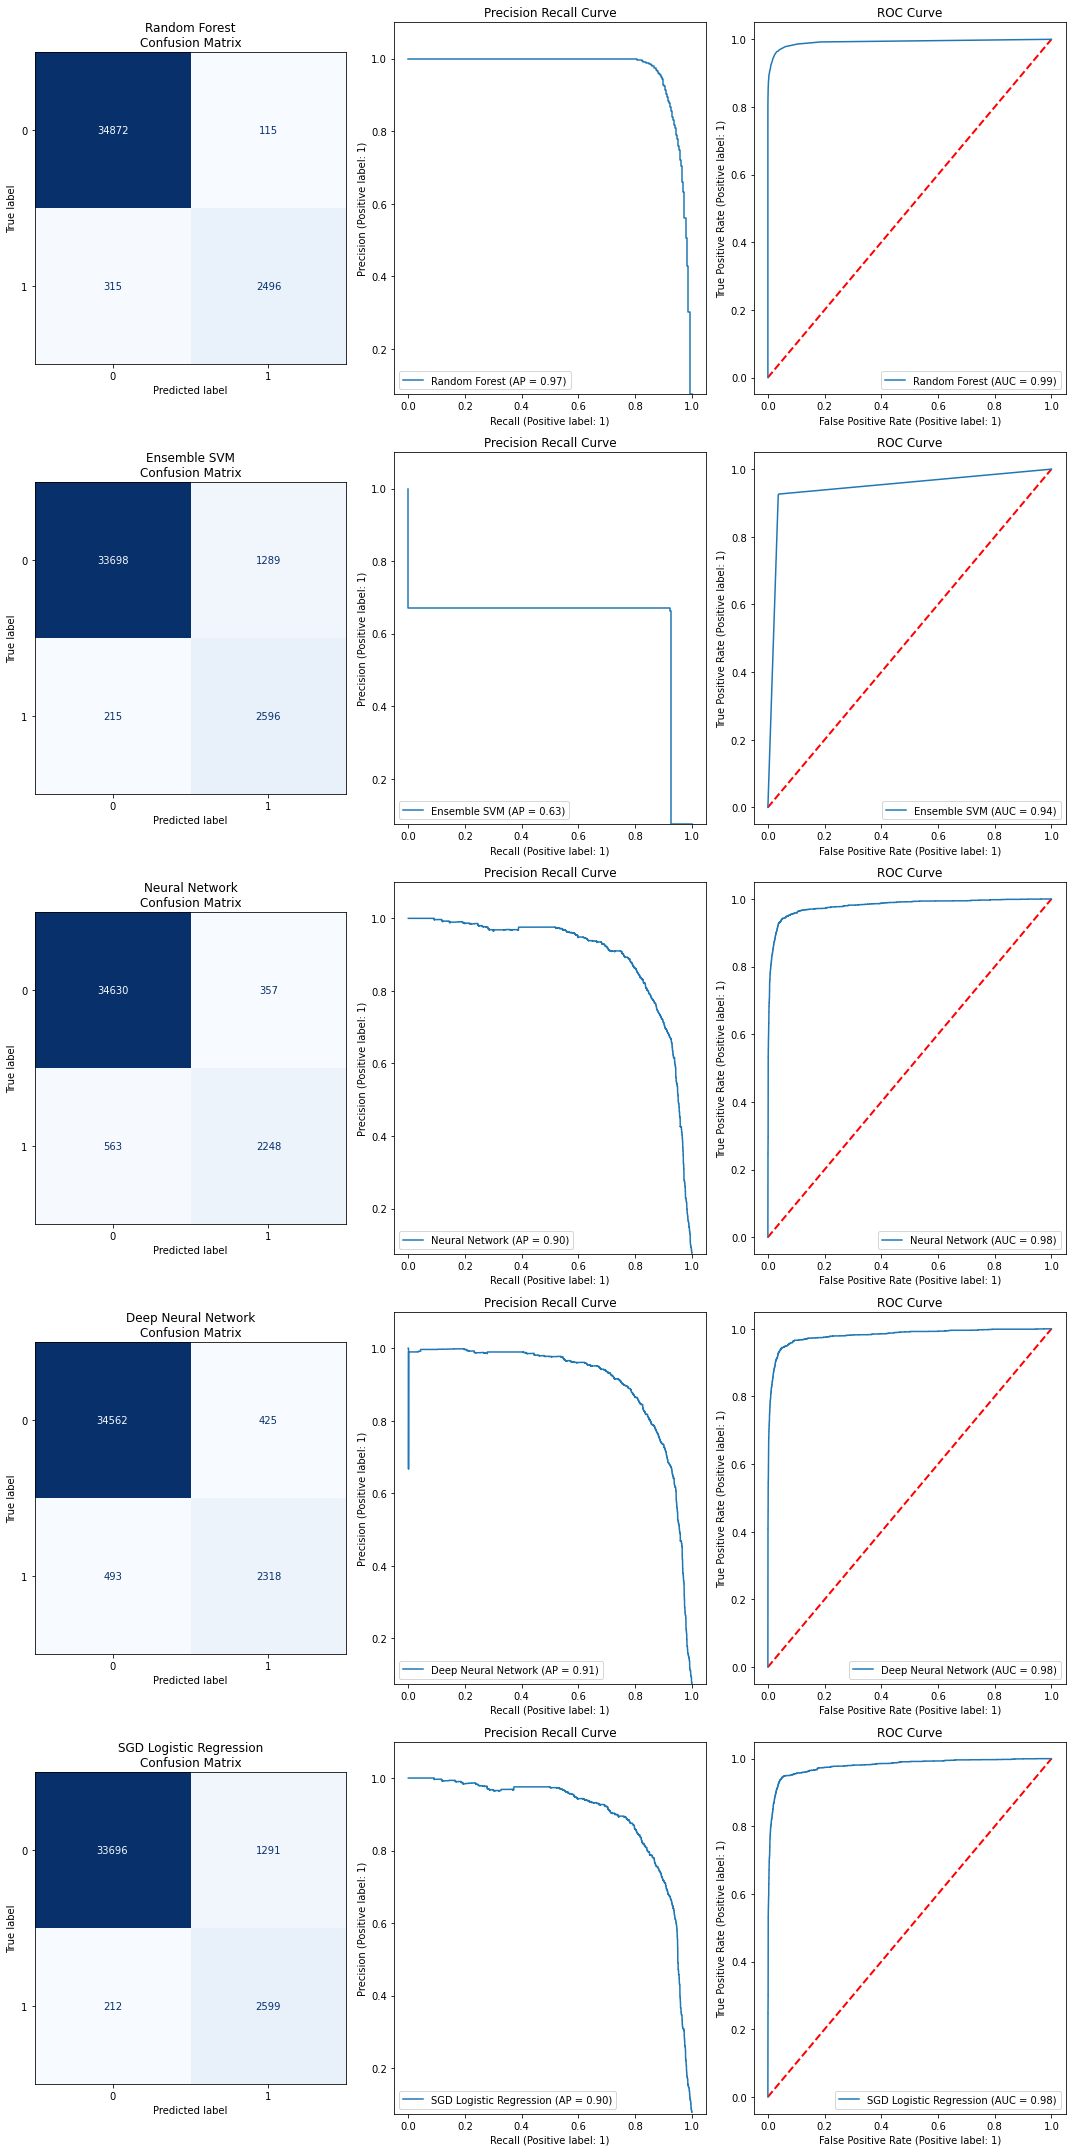

In [ ]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), 
      (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(nrows=5, ncols=3, figsize=(15,30))

ax1.title.set_text('Random Forest\nConfusion Matrix')
metrics.plot_confusion_matrix(rf, x_eval, y_eval, ax=ax1, colorbar=False, cmap='Blues')
ax2.title.set_text('Precision Recall Curve')
ax2.set_ylim(cutoff, 1.1)
metrics.plot_precision_recall_curve(rf, x_eval, y_eval, name='Random Forest', ax=ax2)
ax3.title.set_text('ROC Curve')
ax3.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
metrics.plot_roc_curve(rf, x_eval, y_eval, ax=ax3, name='Random Forest')

ax4.title.set_text('Ensemble SVM\nConfusion Matrix')
metrics.plot_confusion_matrix(svc, x_eval_scale, y_eval, ax=ax4, colorbar=False, cmap='Blues')
ax5.title.set_text('Precision Recall Curve')
ax5.set_ylim(cutoff, 1.1)
metrics.plot_precision_recall_curve(svc, x_eval_scale, y_eval, name='Ensemble SVM', ax=ax5)
ax6.title.set_text('ROC Curve')
ax6.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
metrics.plot_roc_curve(svc, x_eval_scale, y_eval, ax=ax6, name='Ensemble SVM')

ax7.title.set_text('Neural Network\nConfusion Matrix')
metrics.plot_confusion_matrix(nn, x_eval_scale, y_eval, ax=ax7, colorbar=False, cmap='Blues')
ax8.title.set_text('Precision Recall Curve')
ax8.set_ylim(cutoff, 1.1)
metrics.plot_precision_recall_curve(nn, x_eval_scale, y_eval, name='Neural Network', ax=ax8)
ax9.title.set_text('ROC Curve')
ax9.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
metrics.plot_roc_curve(nn, x_eval_scale, y_eval, ax=ax9, name='Neural Network')

ax10.title.set_text('Deep Neural Network\nConfusion Matrix')
metrics.plot_confusion_matrix(dnn, x_eval_scale, y_eval, ax=ax10, colorbar=False, cmap='Blues')
ax11.title.set_text('Precision Recall Curve')
ax11.set_ylim(cutoff, 1.1)
metrics.plot_precision_recall_curve(dnn, x_eval_scale, y_eval, name='Deep Neural Network', ax=ax11)
ax12.title.set_text('ROC Curve')
ax12.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
metrics.plot_roc_curve(dnn, x_eval_scale, y_eval, ax=ax12, name='Deep Neural Network')

ax13.title.set_text('SGD Logistic Regression\nConfusion Matrix')
metrics.plot_confusion_matrix(sgd, x_eval_scale, y_eval, ax=ax13, colorbar=False, cmap='Blues')
ax14.title.set_text('Precision Recall Curve')
ax14.set_ylim(cutoff, 1.1)
metrics.plot_precision_recall_curve(sgd, x_eval_scale, y_eval, name='SGD Logistic Regression', ax=ax14)
ax15.title.set_text('ROC Curve')
ax15.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
metrics.plot_roc_curve(sgd, x_eval_scale, y_eval, ax=ax15, name='SGD Logistic Regression')

#path = os.path.join(root_dir, 'Visualizations/Figures.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.tight_layout()
plt.show()

### Confusion Matrices

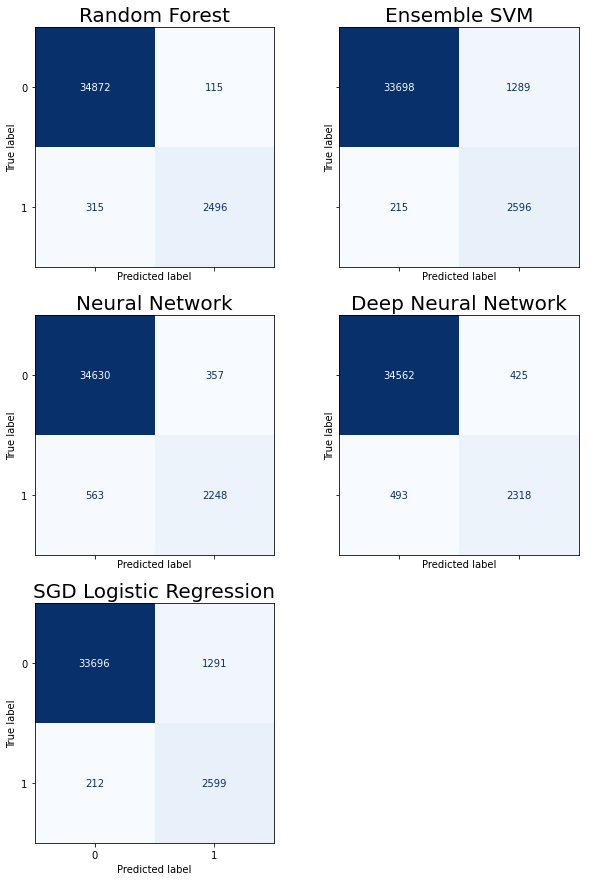

In [ ]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(10,15),sharex=True, sharey=True)

ax1.set_title('Random Forest', fontsize=20)
metrics.plot_confusion_matrix(rf, x_eval, y_eval, ax=ax1, colorbar=False, cmap='Blues')

ax2.set_title('Ensemble SVM', fontsize=20)
metrics.plot_confusion_matrix(svc, x_eval_scale, y_eval, ax=ax2, colorbar=False, cmap='Blues')

ax3.set_title('Neural Network', fontsize=20)
metrics.plot_confusion_matrix(nn, x_eval_scale, y_eval, ax=ax3, colorbar=False, cmap='Blues')

ax4.set_title('Deep Neural Network', fontsize=20)
metrics.plot_confusion_matrix(dnn, x_eval_scale, y_eval, ax=ax4, colorbar=False, cmap='Blues')

ax5.set_title('SGD Logistic Regression', fontsize=20)
metrics.plot_confusion_matrix(sgd, x_eval_scale, y_eval, ax=ax5, colorbar=False, cmap='Blues')

ax6.axis('off')

#path = os.path.join(root_dir, 'Visualizations/Confusion_Matrices.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#            orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

### PR and ROC Curves

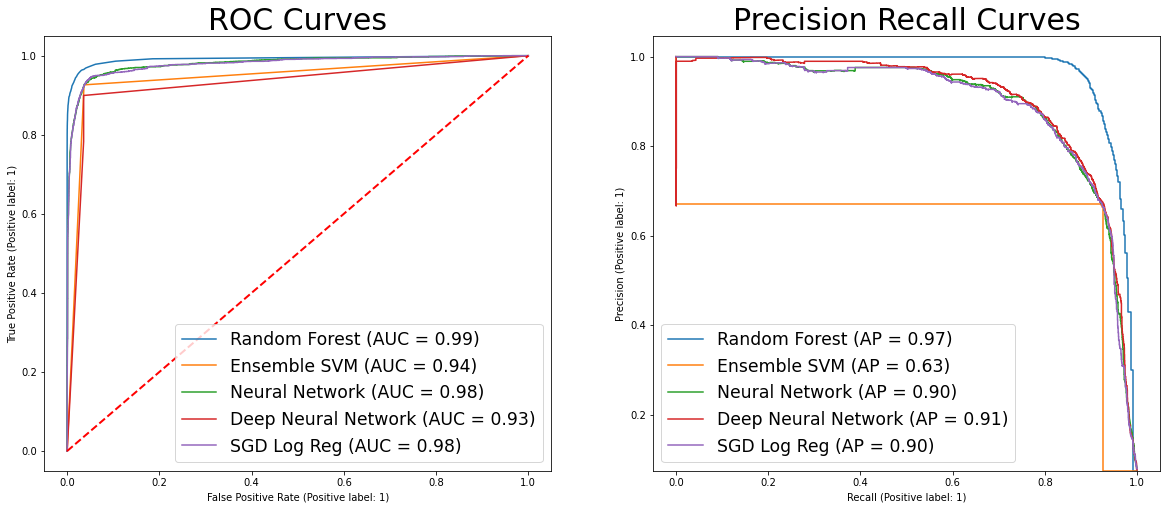

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
metrics.plot_roc_curve(rf, x_eval, y_eval, ax=ax1, name='Random Forest')
metrics.plot_roc_curve(svc, x_eval_scale, y_eval, ax=ax1, name='Ensemble SVM')
metrics.plot_roc_curve(nn, x_eval_scale, y_eval, ax=ax1, name='Neural Network')
metrics.plot_roc_curve(rf, x_eval_scale, y_eval, ax=ax1, name='Deep Neural Network')
metrics.plot_roc_curve(sgd, x_eval_scale, y_eval, ax=ax1, name='SGD Log Reg')
ax1.set_title('ROC Curves', fontsize=30)
ax1.legend(fontsize='xx-large')
ax1.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

metrics.plot_precision_recall_curve(rf, x_eval, y_eval, name='Random Forest', ax=ax2)
metrics.plot_precision_recall_curve(svc, x_eval_scale, y_eval, name='Ensemble SVM', ax=ax2)
metrics.plot_precision_recall_curve(nn, x_eval_scale, y_eval, name='Neural Network', ax=ax2)
metrics.plot_precision_recall_curve(dnn, x_eval_scale, y_eval, name='Deep Neural Network', ax=ax2)
metrics.plot_precision_recall_curve(sgd, x_eval_scale, y_eval, name='SGD Log Reg', ax=ax2)
ax2.set_title('Precision Recall Curves', fontsize=30)
ax2.legend(fontsize='xx-large')
ax2.set_ylim(cutoff)

#path = os.path.join(root_dir, 'Visualizations/ROC_and_PR_Curves.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

### Scores

In [ ]:
accuracy_scores = {"DNN":dnn_report.loc["accuracy"][0],
                   "NN":nn_report.loc["accuracy"][0],
                   "Random Forest":rf_report.loc["accuracy"][0],
                   "SGD Log Reg":sgd_report.loc["accuracy"][0],
                   "Ensemble SVM":svc_report.loc["accuracy"][0]} 

precision_scores = {"DNN":dnn_report.iloc[3][0],
                    "NN":nn_report.iloc[3][0],
                    "Random Forest":rf_report.iloc[3][0], 
                    "SGD Log Reg":sgd_report.iloc[3][0],
                    "Ensemble SVM":svc_report.iloc[3][0]}
recall_scores = {"DNN":dnn_report.iloc[3][1],
                 "NN":nn_report.iloc[3][1],
                 "Random Forest":rf_report.iloc[3][1], 
                 "SGD Log Reg":sgd_report.iloc[3][1],
                 "Ensemble SVM":svc_report.iloc[3][1]}
f1_scores = {"DNN":dnn_report.iloc[3][2],
             "NN":nn_report.iloc[3][2],
             "Random Forest":rf_report.iloc[3][2], 
             "SGD Log Reg":sgd_report.iloc[3][2],
             "Ensemble SVM":svc_report.iloc[3][2]}

accuracy = pd.DataFrame.from_dict(accuracy_scores, orient='index')
precision = pd.DataFrame.from_dict(precision_scores, orient='index')
recall = pd.DataFrame.from_dict(recall_scores, orient='index')
f1 = pd.DataFrame.from_dict(f1_scores, orient='index')

scores = pd.concat([accuracy, precision, recall, f1], axis=1)
scores.columns = ['Accuracy', 'Precision', 'Recall', 'F1']

scores

,Accuracy,Precision,Recall,F1
DNN,0.975713,0.915498,0.906235,0.910804
NN,0.975660,0.923479,0.894756,0.908512
Random Forest,0.988624,0.973502,0.942327,0.957283
SGD Log Reg,0.960236,0.830936,0.943841,0.876945
Ensemble SVM,0.960210,0.830936,0.943336,0.876780


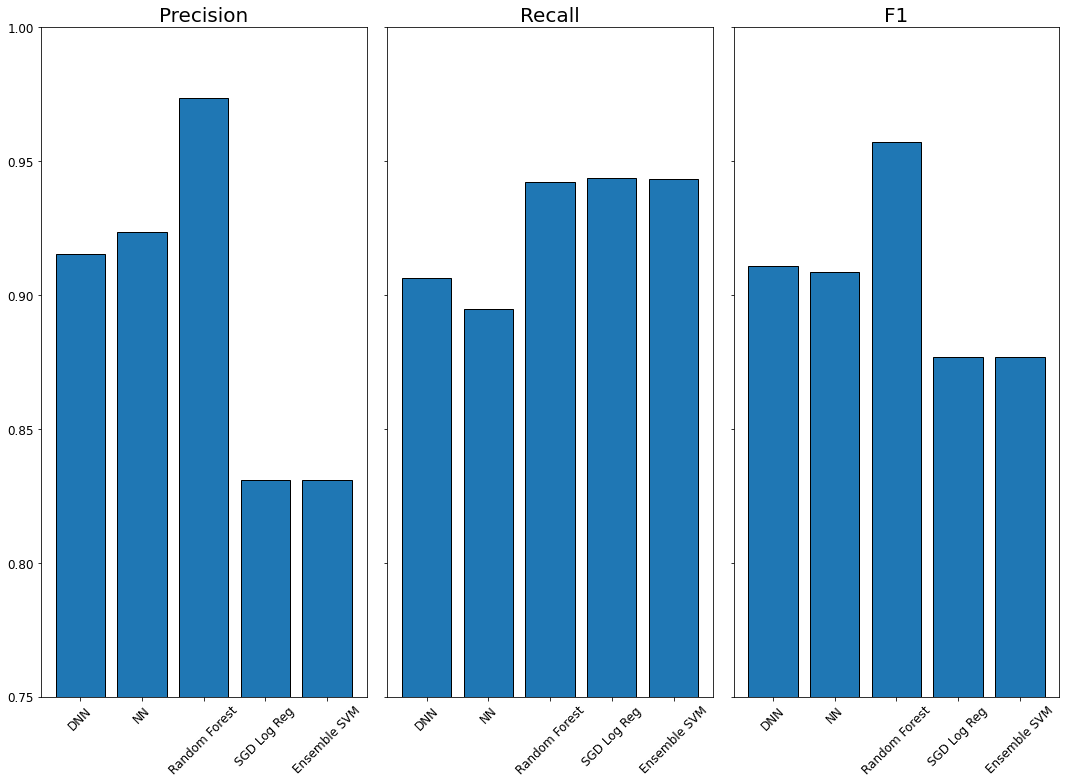

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15,11), sharey=True, sharex=True)

ax1.set_title('Precision', fontsize=20)
ax1.bar(x=scores.index, height=scores['Precision'], edgecolor='Black')
ax1.tick_params(axis='x', rotation=45, labelsize='large')

ax2.set_title('Recall', fontsize=20)
ax2.bar(x=scores.index, height=scores['Recall'], edgecolor='Black')
ax2.tick_params(axis='x', rotation=45, labelsize='large')

ax3.set_title('F1', fontsize=20)
ax3.bar(x=scores.index, height=scores['F1'], edgecolor='Black')
ax3.tick_params(axis='x', rotation=45, labelsize='large')

ax1.set_ylim(bottom=.75, top=1.0)
ax1.tick_params(axis='y', labelsize='large')

#path = os.path.join(root_dir, 'Visualizations/Results.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.tight_layout()
plt.show()

# Spatial Statistics

## Prepare Data

In [ ]:
oid = pd.DataFrame(data[['POINT_X', 'POINT_Y']])

predictions = pd.DataFrame(y_eval)
predictions["pred"] = rf_pred

pred = predictions.join(oid, on=predictions.index, how='left')
pred['true'] = np.where(pred['Attack'] == pred['pred'], 1, 0)
pred['true'].value_counts()

1    37368
0      430
Name: true, dtype: int64

In [ ]:
pred['false_neg'] = (pred['Attack'] == 1) & (pred['pred'] == 0)
pred['false_pos'] = (pred['Attack'] == 0) & (pred['pred'] == 1)
pred['false_neg'] = pred['false_neg'].replace({True: 1, False:0})
pred['false_pos'] = pred['false_pos'].replace({True: 1, False: 0})
pred

,Attack,pred,POINT_X,POINT_Y,true,false_neg,false_pos
29062,0,0,-1.071348e+06,1353217,1,0,0
224204,0,0,-2.573010e+05,3537857,1,0,0
250930,0,0,7.293725e+05,4203513,1,0,0
146106,0,0,8.829223e+05,2266601,1,0,0
37544,0,0,7.479846e+05,1415004,1,0,0
...,...,...,...,...,...,...,...
113267,0,0,-2.384565e+05,2070492,1,0,0
213414,0,0,3.803957e+05,3174613,1,0,0
231689,0,0,8.038209e+05,3671601,1,0,0
214405,0,0,8.165941e+05,3207670,1,0,0


In [ ]:
gdf = geopandas.GeoDataFrame(pred, geometry=geopandas.points_from_xy(pred.POINT_X, pred.POINT_Y))
gdf.drop(columns=['Attack', 'pred'], inplace=True)

In [ ]:
europe = geopandas.read_file('Data/Europe.shp')
europe = europe[europe.REGION == 'EUROPE-SW ASIA']
europe.head()

,Name,REGION,iso_alpha3,geometry
2,ALBANIA,EUROPE-SW ASIA,ALB,"POLYGON ((19.72424 42.66103, 19.72708 42.66075..."
5,ANDORRA,EUROPE-SW ASIA,AND,"POLYGON ((1.55599 42.65329, 1.58493 42.63381, ..."
12,AUSTRIA,EUROPE-SW ASIA,AUT,"POLYGON ((15.02888 49.01590, 15.06495 49.00047..."
15,BELARUS,EUROPE-SW ASIA,BLR,"MULTIPOLYGON (((28.10388 56.54194, 28.10472 56..."
16,BELGIUM,EUROPE-SW ASIA,BEL,"POLYGON ((4.87050 51.41293, 4.86931 51.41179, ..."


## Visualize Results

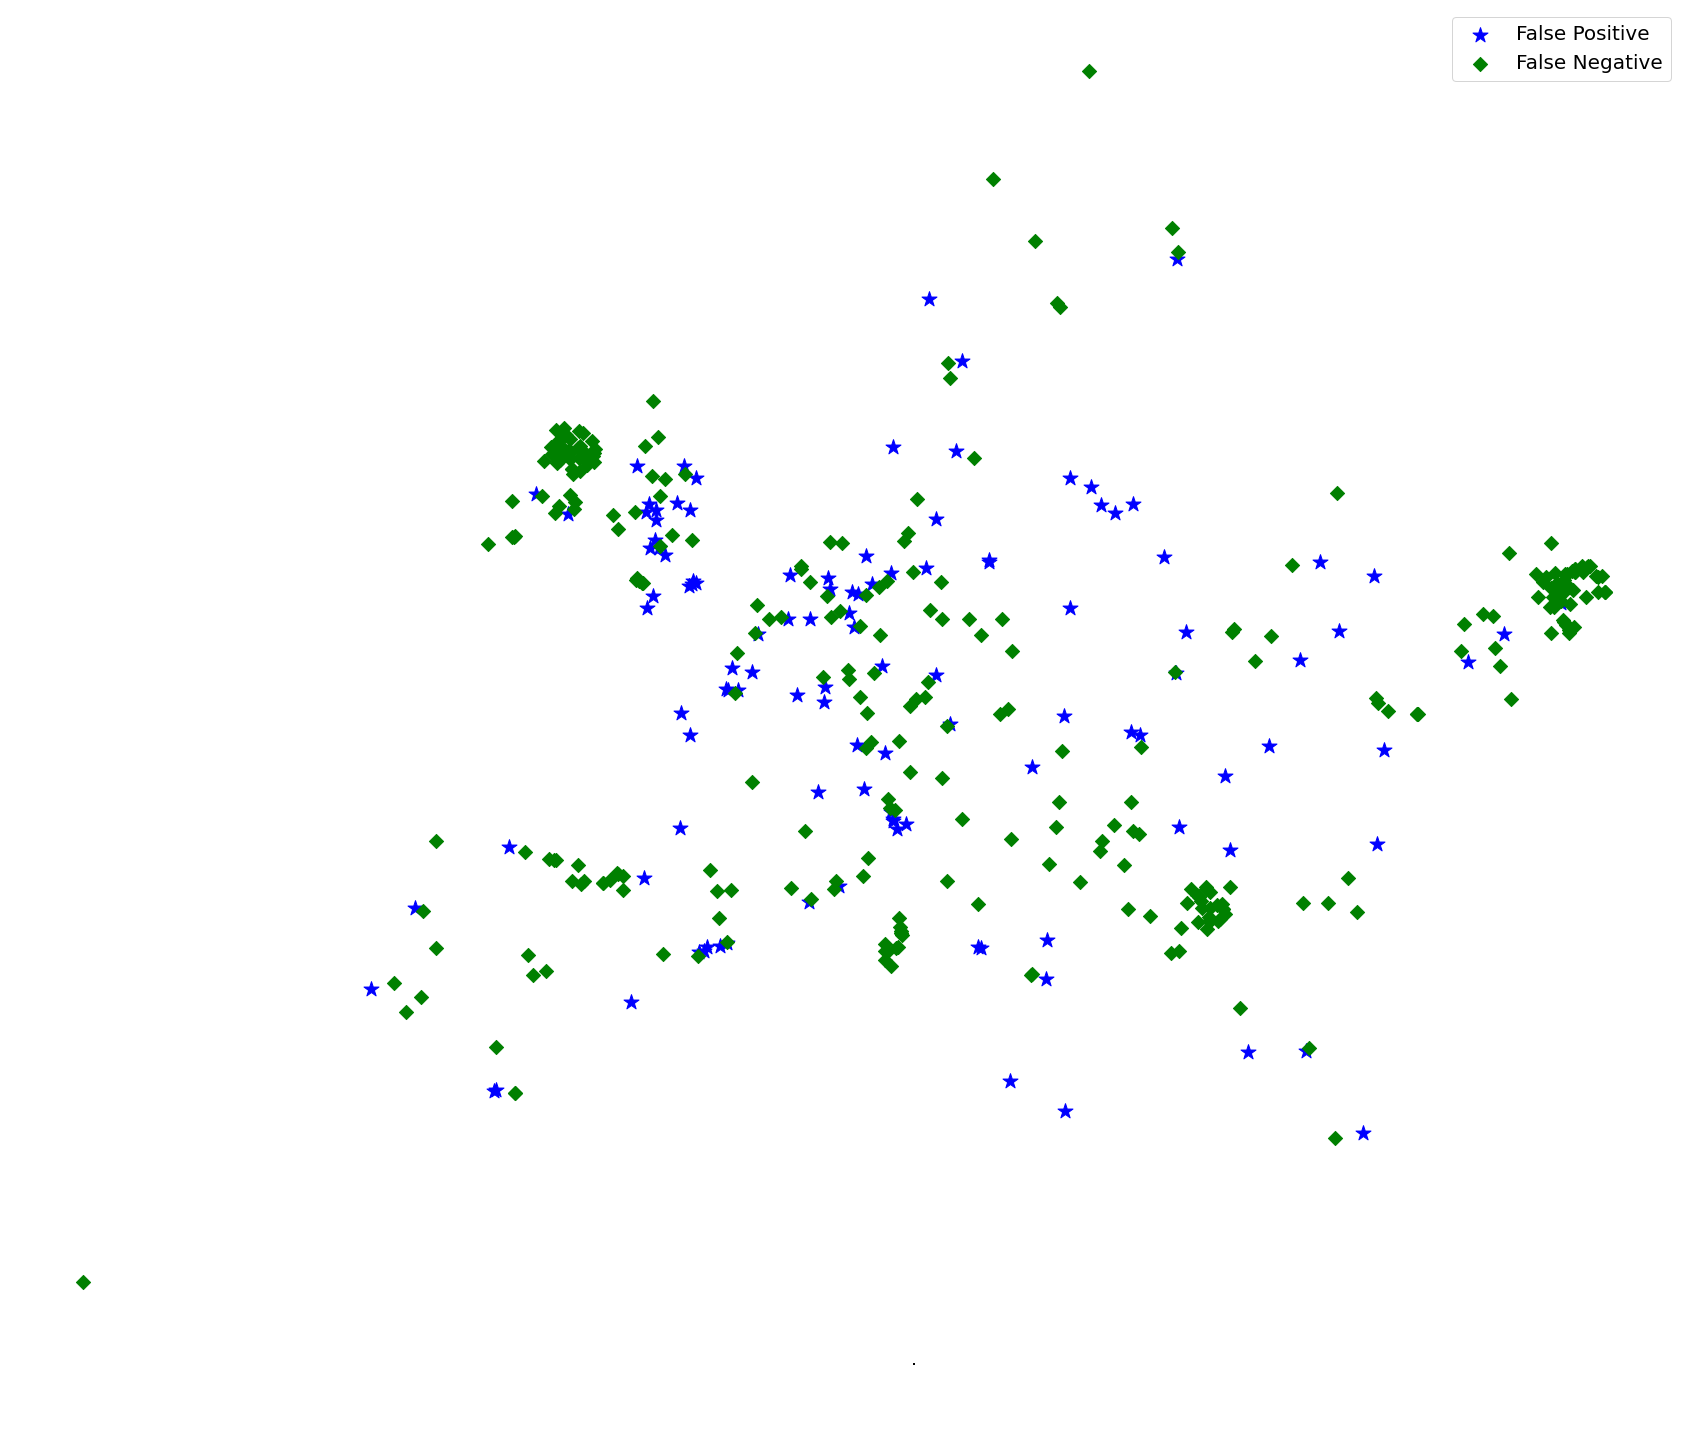

In [ ]:
fig, ax = plt.subplots(figsize = (30, 30))

europe.plot(ax=ax, color='none', edgecolor='black') 

gdf[gdf['false_pos'] == 1].plot( 
            ax = ax,           
            markersize = 250, 
            color = "blue", 
            marker = '*', 
            label = "False Positive")

gdf[gdf['false_neg'] == 1].plot( 
            ax = ax,           
            markersize = 100, 
            color = "green", 
            marker = 'D', 
            label = "False Negative")

plt.legend(prop={'size':20})

ax.axis('off')

plt.show()

## Calculate Join Counts

In [ ]:
wq_true = lp.weights.Queen.from_dataframe(gdf)
wq_true.transform='b'
jc_true = esda.join_counts.Join_Counts(gdf['true'], wq_true)

wq_false_neg = lp.weights.Queen.from_dataframe(gdf)
wq_false_neg.transform='b'
jc_false_neg = esda.join_counts.Join_Counts(gdf['false_neg'], wq_false_neg)

wq_false_pos = lp.weights.Queen.from_dataframe(gdf)
wq_false_pos.transform='b'
jc_false_pos = esda.join_counts.Join_Counts(gdf['false_pos'], wq_false_pos)

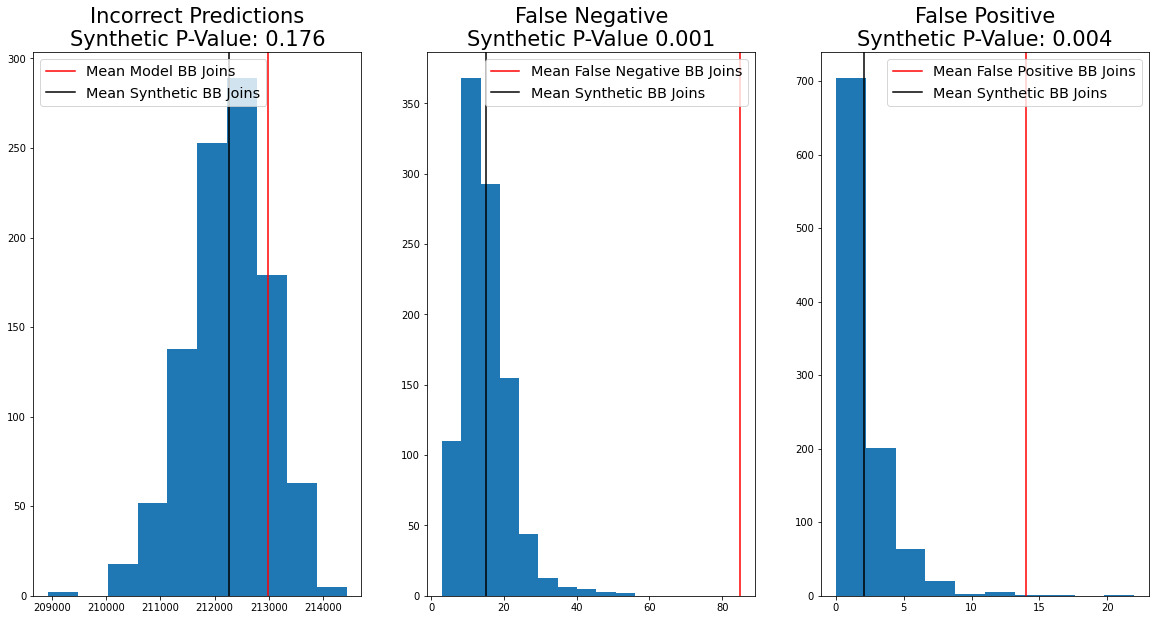

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(20,10))

ax1.hist(jc_true.sim_bb)
ax1.axvline(jc_true.bb, color='r', label='Mean Model BB Joins')
ax1.axvline(jc_true.mean_bb, color='black', label='Mean Synthetic BB Joins')

ax1.set_title(f'Incorrect Predictions\nSynthetic P-Value: {jc_true.p_sim_bb}', fontdict={'fontsize':21})
ax1.legend(fontsize='x-large')

ax2.hist(jc_false_neg.sim_bb)
ax2.axvline(jc_false_neg.bb, color='r', label='Mean False Negative BB Joins')
ax2.axvline(jc_false_neg.mean_bb, color='black', label='Mean Synthetic BB Joins')

ax2.set_title(f'False Negative\nSynthetic P-Value {jc_false_neg.p_sim_bb}', fontdict={'fontsize':21})
ax2.legend(fontsize='x-large')

ax3.hist(jc_false_pos.sim_bb)
ax3.axvline(jc_false_pos.bb, color='r', label='Mean False Positive BB Joins')
ax3.axvline(jc_false_pos.mean_bb, color='black', label='Mean Synthetic BB Joins')

ax3.set_title(f'False Positive\nSynthetic P-Value: {jc_false_pos.p_sim_bb}', fontdict={'fontsize':21})
ax3.legend(fontsize='x-large')

path = os.path.join(root_dir, 'Visualizations/Join_Count_Histograms.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

## Clustering Analysis

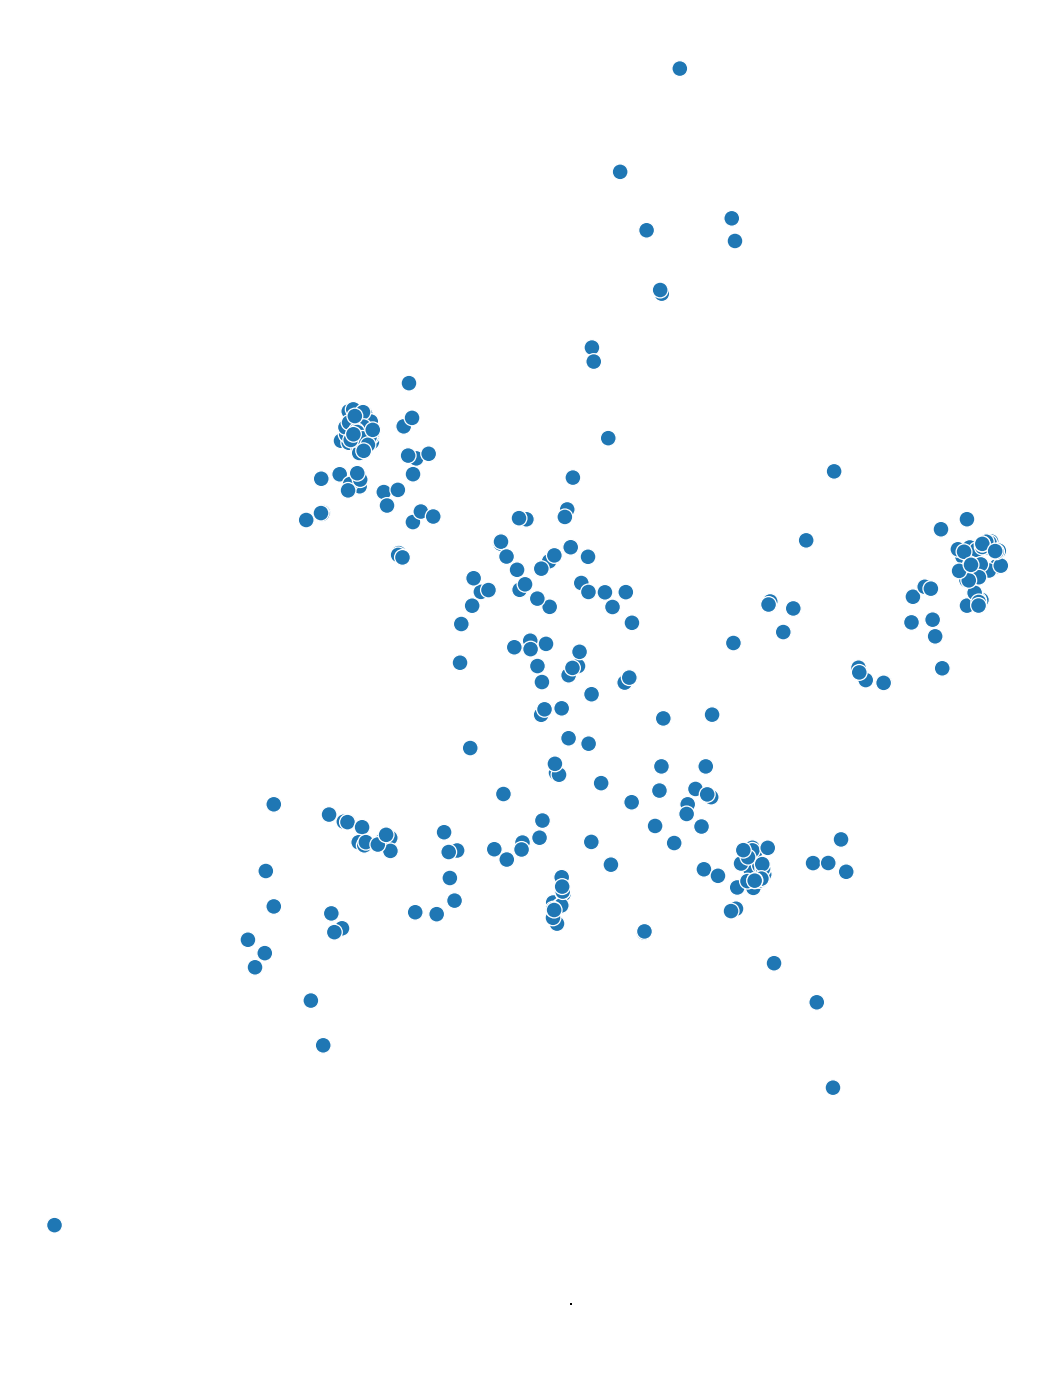

In [ ]:
df_false_neg = pd.DataFrame(gdf.loc[(gdf['false_neg'] == 1)])
df_false_neg.drop(columns='geometry', inplace=True)

clustering_false_neg = DBSCAN(eps=1.0, min_samples=5).fit(df_false_neg)

labels_false_neg = clustering_false_neg.labels_

fig, ax = plt.subplots(figsize=(25,25))

#plt.title('Clusters of False Negative Predictions (eps = 1.0 & samples = 5)', fontsize=30)

europe.plot(ax=ax, color='none', edgecolor='black')
sns.scatterplot(data=df_false_neg, x= df_false_neg.iloc[:,0], y=df_false_neg.iloc[:,1], 
                hue=["cluster-{}".format(x) for x in labels_false_neg], s=250, legend=False)
ax.axis('off')

#path = os.path.join(root_dir, 'Visualizations/False_Negative_Clusters.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

In [ ]:
df_false_pos = pd.DataFrame(gdf.loc[(gdf['false_pos'] == 1)])
df_false_pos.drop(columns='geometry', inplace=True)

clustering_false_pos = DBSCAN(eps=1.0, min_samples=5).fit(df_false_pos)

labels_false_pos = clustering_false_pos.labels_

fig, ax = plt.subplots(figsize=(25,25))

#plt.title('Clusters of False Positive Predictions (eps = 1.0 & samples = 5)', fontsize=30)

europe.plot(ax=ax, color='none', edgecolor='black')
sns.scatterplot(data=df_false_pos, x= df_false_pos.iloc[:,0], y=df_false_pos.iloc[:,1], 
                hue=["cluster-{}".format(x) for x in labels_false_pos], s=250, legend=False)
ax.axis('off')

#path = os.path.join(root_dir, 'Visualizations/False_Positive_Clusters.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#        orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

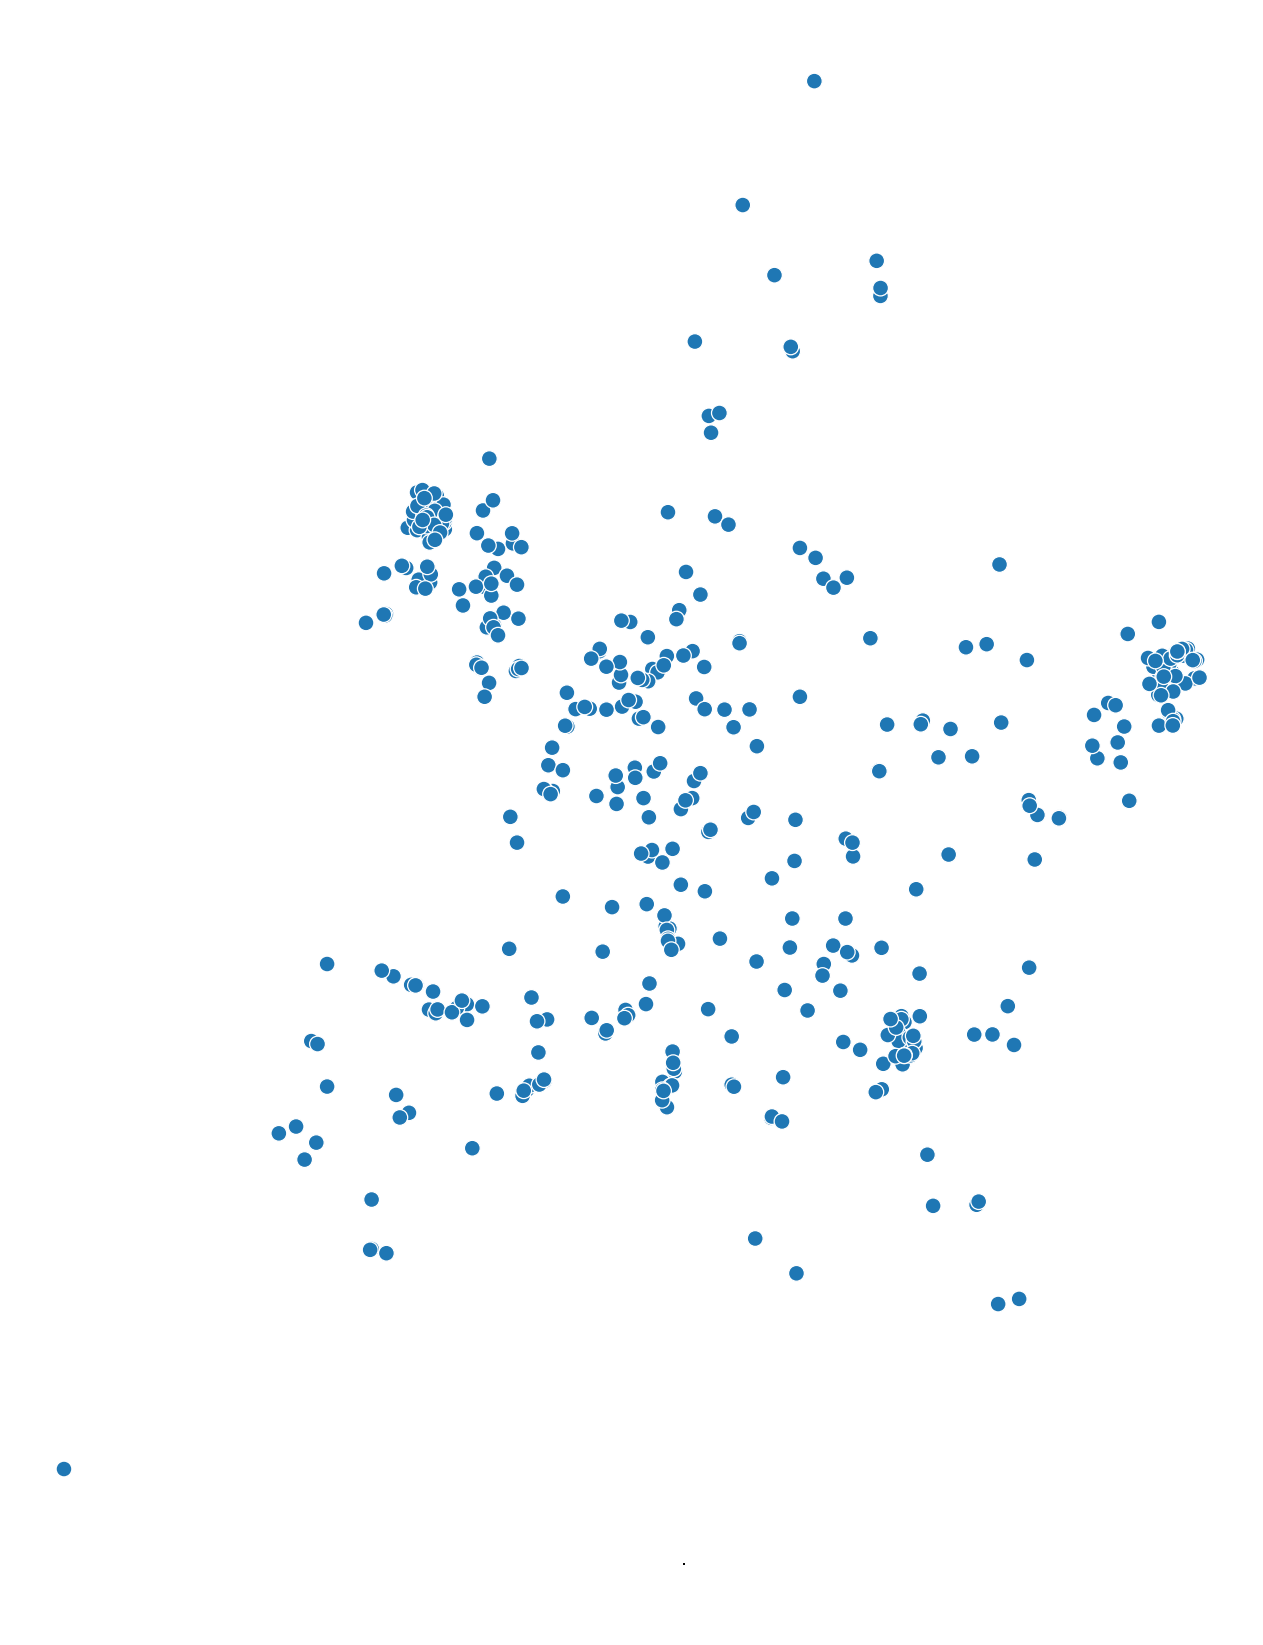

In [ ]:
df_true = pd.DataFrame(gdf.loc[(gdf['true'] == 0)])
df_true.drop(columns='geometry', inplace=True)

clustering_true = DBSCAN(eps=1.0, min_samples=6).fit(df_true)

labels_true = clustering_true.labels_

fig, ax = plt.subplots(figsize=(30,30))

#plt.title('Clusters of Correct Predictions (eps = 1.0 & samples = 5)', fontsize=35)

europe.plot(ax=ax, color='none', edgecolor='black')
sns.scatterplot(data=df_true, x= df_true.iloc[:,0], y=df_true.iloc[:,1], 
                hue=["cluster-{}".format(x) for x in labels_true], s=250, legend=False)
ax.axis('off')

plt.show()

# Final Prediction and Evaluation

In [ ]:
eval_df = data.drop(['f_15_49', 'pop_count', 'built_settlement_growth', 'snow/ice/water', 
              'vegetation', 'gdp', 'impervious_land', 'forest'], axis=1)

sample_1 = eval_df.groupby('Attack').sample(frac=.75, random_state=1)
sample_2 = eval_df.groupby('Attack').sample(frac=.75, random_state=2)
sample_3 = eval_df.groupby('Attack').sample(frac=.75, random_state=3)

x_1 = sample_1.iloc[:,4:]
y_1 = sample_1.iloc[:,3]

x_2 = sample_2.iloc[:,4:]
y_2 = sample_2.iloc[:,3]

x_3 = sample_3.iloc[:,4:]
y_3 = sample_3.iloc[:,3]

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size=.3, stratify=y_1, random_state=1)
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(x_2, y_2, test_size=.3, stratify=y_2, random_state=1)
x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(x_3, y_3, test_size=.3, stratify=y_3, random_state=1)

rf_1 = RandomForestClassifier(n_jobs=-1, random_state=1)
rf_2 = RandomForestClassifier(n_jobs=-1, random_state=1)
rf_3 = RandomForestClassifier(n_jobs=-1, random_state=1)

rf_1.fit(x_train_1, y_train_1)
rf_2.fit(x_train_2, y_train_2)
rf_3.fit(x_train_3, y_train_3)

print(f"Model 1 Score: {rf_1.score(x_test_1, y_test_1)}")
print(f"Model 2 Score: {rf_2.score(x_test_2, y_test_2)}")
print(f"Model 3 Score: {rf_3.score(x_test_3, y_test_3)}")

Model 1 Score: 0.9883593777558292
Model 2 Score: 0.9883064658365375
Model 3 Score: 0.9877244347243289


In [ ]:
final_pred = rf.predict(x_test)
final_report = pd.DataFrame(classification_report(y_test,final_pred,output_dict=True)).transpose()
final_report

,precision,recall,f1-score,support
0,0.990708,0.996427,0.993559,34988.000000
1,0.952089,0.883671,0.916605,2811.000000
accuracy,0.988042,0.988042,0.988042,0.988042
macro avg,0.971398,0.940049,0.955082,37799.000000
weighted avg,0.987836,0.988042,0.987836,37799.000000


## Feature Importance

In [ ]:
x_test.rename(columns = {'dist_inland_water': "Distance to Inland Water", 
               'dist_maj_road': 'Distance to Major Roadway', 
               'dist_maj_road_int': 'Distance to Major Road Intersection', 
               'dist_maj_waterway': 'Distance to Major Waterway', 
               'elevation':'Elevation', 
               'civil_unrest': 'Civil Unrest', 
               'pop_density': 'Population Density', 
               'slope': 'Slope', 
               'nighttime_lights': 'Nighttime Lights', 
               'urban': 'Urban', 
               'agriculture': 'Agriculture'}, inplace=True)

In [ ]:
feature_importance = rf.feature_importances_
indices = np.argsort(feature_importance)[::-1]
labels = x_test.columns
labels

Index(['Distance to Inland Water', 'dist_majroad', 'dist_majroad_int',
       'Distance to Major Waterway', 'Elevation', 'Civil Unrest',
       'Population Density', 'Slope', 'Nighttime Lights', 'Urban',
       'Agriculture'],
      dtype='object')

In [ ]:
for f in range(x_test.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                           labels[indices[f]],
                           feature_importance[indices[f]]))

 1) Urban                          0.278113
 2) Population Density             0.277410
 3) Nighttime Lights               0.125096
 4) dist_majroad_int               0.097222
 5) dist_majroad                   0.068931
 6) Elevation                      0.044596
 7) Civil Unrest                   0.038537
 8) Agriculture                    0.022501
 9) Slope                          0.017461
10) Distance to Inland Water       0.017363
11) Distance to Major Waterway     0.012769


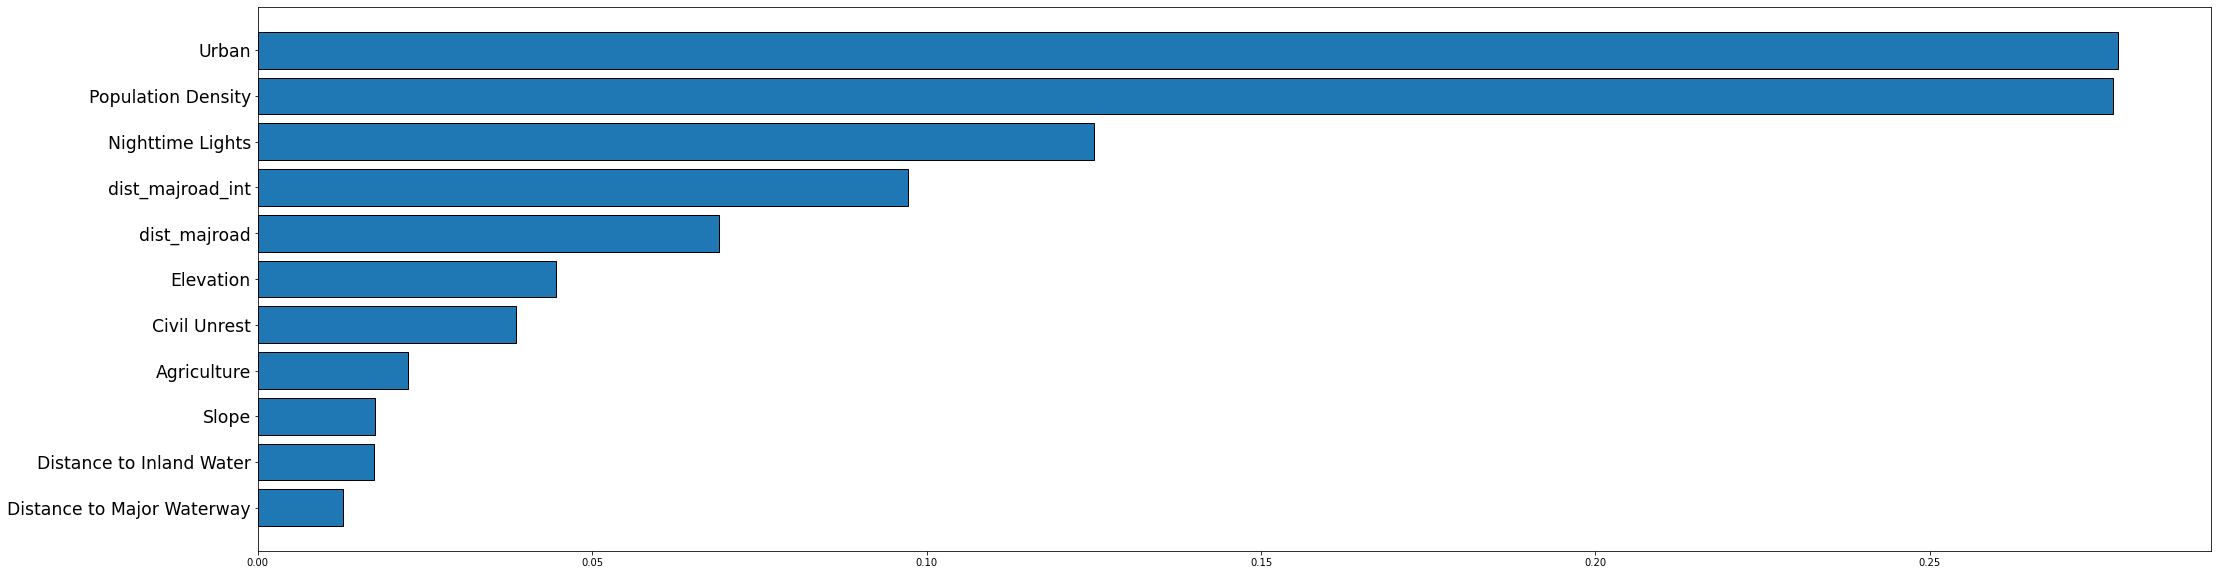

In [ ]:
unsorted_list = [(feature_importance, labels) for labels, feature_importance in 
                  zip(labels, feature_importance)]
sorted_list = sorted(unsorted_list)

features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

fig, ax = plt.subplots(figsize=(35,10))

plt.barh(range(len(importance_sorted)), importance_sorted, edgecolor='black')
plt.yticks(range(len(importance_sorted)), features_sorted)
plt.tick_params(axis='y', labelsize ='xx-large')

#path = os.path.join(root_dir, 'Visualizations/Feature_Importance.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#            orientation='portrait', transparent=False, bbox_inches=None, pad_inches=0.1)

plt.show()

# Temporal Analysis

## Read Data In

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from matplotlib.dates import date2num
from datetime import datetime
import seaborn as sns
from scipy.signal import find_peaks

In [ ]:
# Read in ICEWS Datasets 2000 - 2018
events_00 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2000.20150313082808.tab/events.2000.20150313082808.tab'), sep='\t', low_memory=False)
events_01 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2001.20150313082922.tab/events.2001.20150313082922.tab'), sep='\t', low_memory=False)
events_02 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2002.20150313083053.tab/events.2002.20150313083053.tab'), sep='\t', low_memory=False)
events_03 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2003.20150313083228.tab/events.2003.20150313083228.tab'), sep='\t', low_memory=False)
events_04 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2004.20150313083407.tab/events.2004.20150313083407.tab'), sep='\t', low_memory=False)
events_05 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2005.20150313083555.tab/events.2005.20150313083555.tab'), sep='\t', low_memory=False)
events_06 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2006.20150313083752.tab/events.2006.20150313083752.tab'), sep='\t', low_memory=False)
events_07 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2007.20150313083959.tab/events.2007.20150313083959.tab'), sep='\t', low_memory=False)
events_08 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2008.20150313084156.tab/events.2008.20150313084156.tab'), sep='\t', low_memory=False)
events_09 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2009.20150313084349.tab/events.2009.20150313084349.tab'), sep='\t', low_memory=False)
events_10 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2010.20150313084533.tab/events.2010.20150313084533.tab'), sep='\t', low_memory=False)
events_11 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2011.20150313084656.tab/events.2011.20150313084656.tab'), sep='\t', low_memory=False)
events_12 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2012.20150313084811.tab/events.2012.20150313084811.tab'), sep='\t', low_memory=False)
events_13 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2013.20150313084929.tab/events.2013.20150313084929.tab'), sep='\t', low_memory=False)
events_14 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2014.20160121105408.tab'), sep='\t', low_memory=False)
events_15 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2015.20180710092545.tsv'), sep='\t', low_memory=False)
events_16 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2016.20180710092843.tsv'), sep='\t', low_memory=False)
events_17 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/Events.2017.20201119/Events.2017.20201119.tab'), sep='\t', low_memory=False)
events_18 = pd.read_csv(os.path.join(root_dir, 'Data/ICEWS_00_18/events.2018.20200427084805.tab'), sep='\t', low_memory=False)

# Read in GTD Dataset
terror = pd.read_csv(os.path.join(root_dir, 'Data/globalterrorismdb.csv'), low_memory=False)

## Prepare Data

In [ ]:
# Concat ICEWS data into one dataframe
icews = pd.concat([events_00, events_01, events_02, events_03, events_04, events_05, events_06, events_07,
                   events_08, events_09, events_10, events_11, events_12, events_13, events_14, events_15, 
                   events_16, events_17, events_18], axis=0)

In [ ]:
# Specify AOI
aoi = ['Spain', 'Malta', 'Greece', 'Portugal', 'Italy', 'Albania', 'Macedonia', 'France', 'Vatican City', 
       'Yugoslavia', 'Croatia', 'Montenegro', 'Kosovo', 'Serbia-Montenegro', 'Serbia', 'Bulgaria', 
       'Bosnia-Herzegovina', 'Romania', 'Ukraine', 'Switzerland', 'Slovenia', 'Germany', 'Austria', 
       'Czechoslovakia', 'Slovak Republic', 'Hungary', 'Moldova', 'Luxembourg', 'Czech Republic', 'Ireland', 
       'United Kingdom', 'Belgium', 'Netherlands', 'Poland', 'Belarus', 'Lithuania', 'Denmark', 'Sweden', 
       'Latvia', 'Estonia', 'Norway', 'Finland']

In [ ]:
# Filter ICEWS/terror by AOI and temporal range
x = icews.loc[(icews['Source Country'].isin(aoi)) & 
              (icews['Target Country'].isin(aoi))]
y = terror.loc[(terror['country_txt'].isin(aoi)) & 
               (terror['iyear'] > 1999) & 
               (terror['iday'] != 0)]

In [ ]:
# Prepare data for datetime creation
x[['Year', 'Day', 'Month']] = x['Event Date'].str.split('-', expand=True).astype(str)
x['Date'] = pd.to_datetime(x['Event Date'])

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Converting data for datetime prep
x['Day'].mask(x['Day'] == '1', '01', inplace=True)
x['Day'].mask(x['Day'] == '2', '02', inplace=True)
x['Day'].mask(x['Day'] == '3', '03', inplace=True)
x['Day'].mask(x['Day'] == '4', '04', inplace=True)
x['Day'].mask(x['Day'] == '5', '05', inplace=True)
x['Day'].mask(x['Day'] == '6', '06', inplace=True)
x['Day'].mask(x['Day'] == '7', '07', inplace=True)
x['Day'].mask(x['Day'] == '8', '08', inplace=True)
x['Day'].mask(x['Day'] == '9', '09', inplace=True)

x['Month'].mask(x['Month'] == '1', '01', inplace=True)
x['Month'].mask(x['Month'] == '2', '02', inplace=True)
x['Month'].mask(x['Month'] == '3', '03', inplace=True)
x['Month'].mask(x['Month'] == '4', '04', inplace=True)
x['Month'].mask(x['Month'] == '5', '05', inplace=True)
x['Month'].mask(x['Month'] == '6', '06', inplace=True)
x['Month'].mask(x['Month'] == '7', '07', inplace=True)
x['Month'].mask(x['Month'] == '8', '08', inplace=True)
x['Month'].mask(x['Month'] == '9', '09', inplace=True)

y[['iday', 'imonth', 'iyear']] = y[['iday', 'imonth', 'iyear']].astype(str)

y['iday'].mask(y['iday'] == '1', '01', inplace=True)
y['iday'].mask(y['iday'] == '2', '02', inplace=True)
y['iday'].mask(y['iday'] == '3', '03', inplace=True)
y['iday'].mask(y['iday'] == '4', '04', inplace=True)
y['iday'].mask(y['iday'] == '5', '05', inplace=True)
y['iday'].mask(y['iday'] == '6', '06', inplace=True)
y['iday'].mask(y['iday'] == '7', '07', inplace=True)
y['iday'].mask(y['iday'] == '8', '08', inplace=True)
y['iday'].mask(y['iday'] == '9', '09', inplace=True)

y['imonth'].mask(y['imonth'] == '1', '01', inplace=True)
y['imonth'].mask(y['imonth'] == '2', '02', inplace=True)
y['imonth'].mask(y['imonth'] == '3', '03', inplace=True)
y['imonth'].mask(y['imonth'] == '4', '04', inplace=True)
y['imonth'].mask(y['imonth'] == '5', '05', inplace=True)
y['imonth'].mask(y['imonth'] == '6', '06', inplace=True)
y['imonth'].mask(y['imonth'] == '7', '07', inplace=True)
y['imonth'].mask(y['imonth'] == '8', '08', inplace=True)
y['imonth'].mask(y['imonth'] == '9', '09', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:9011: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cond, other, inplace, axis, level, errors=errors, try_cast=try_cast
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
# Convert to datetime
y['Date'] = y[['iyear', 'imonth', 'iday']].agg('-'.join, axis=1)
y['Date'] = pd.to_datetime(y['Date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
x['Week'] = x['Date'].dt.strftime('%U')
y['Week'] = y['Date'].dt.strftime('%U')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Count of events for analysis
y['Y'] = 1
x['X'] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Normalize both datasets to 0/1 scale per day 
yd_count = pd.Series((((y.groupby('Date')['Y'].count() - 
                        y.groupby('Date')['Y'].count().min()) / 
                       (y.groupby('Date')['Y'].count().max() - 
                        y.groupby('Date')['Y'].count().min())) * 1)).sort_index(ascending=True).asfreq('D').fillna(0)
xd_count = pd.Series((((x.groupby('Date')['X'].count() - 
                        x.groupby('Date')['X'].count().min()) / 
                       (x.groupby('Date')['X'].count().max() - 
                        x.groupby('Date')['X'].count().min())) * 1)).sort_index(ascending=True).asfreq('D').fillna(0)

In [ ]:
# Normalize both datasets to 0/1 scale per month 
ym_count = pd.Series((((y.groupby('Date')['Y'].count() - 
                        y.groupby('Date')['Y'].count().min()) / 
                       (y.groupby('Date')['Y'].count().max() - 
                        y.groupby('Date')['Y'].count().min())) * 1)).sort_index(ascending=True).asfreq('M').fillna(0)
xm_count = pd.Series((((x.groupby('Date')['X'].count() - 
                        x.groupby('Date')['X'].count().min()) / 
                       (x.groupby('Date')['X'].count().max() - 
                        x.groupby('Date')['X'].count().min())) * 1)).sort_index(ascending=True).asfreq('M').fillna(0)

In [ ]:
# Normalize both datasets to 0/1 scale per week
yw_count = pd.Series((((y.groupby('Date')['Y'].count() - 
                        y.groupby('Date')['Y'].count().min()) / 
                       (y.groupby('Date')['Y'].count().max() - 
                        y.groupby('Date')['Y'].count().min())) * 1)).sort_index(ascending=True).asfreq('W').fillna(0)
xw_count = pd.Series((((x.groupby('Date')['X'].count() - 
                        x.groupby('Date')['X'].count().min()) / 
                       (x.groupby('Date')['X'].count().max() - 
                        x.groupby('Date')['X'].count().min())) * 1)).sort_index(ascending=True).asfreq('W').fillna(0)

## Data Exploration

### Initial Finding 1:
ICEWS data is fairly normally distributed. However, terrorism data is skewed right.

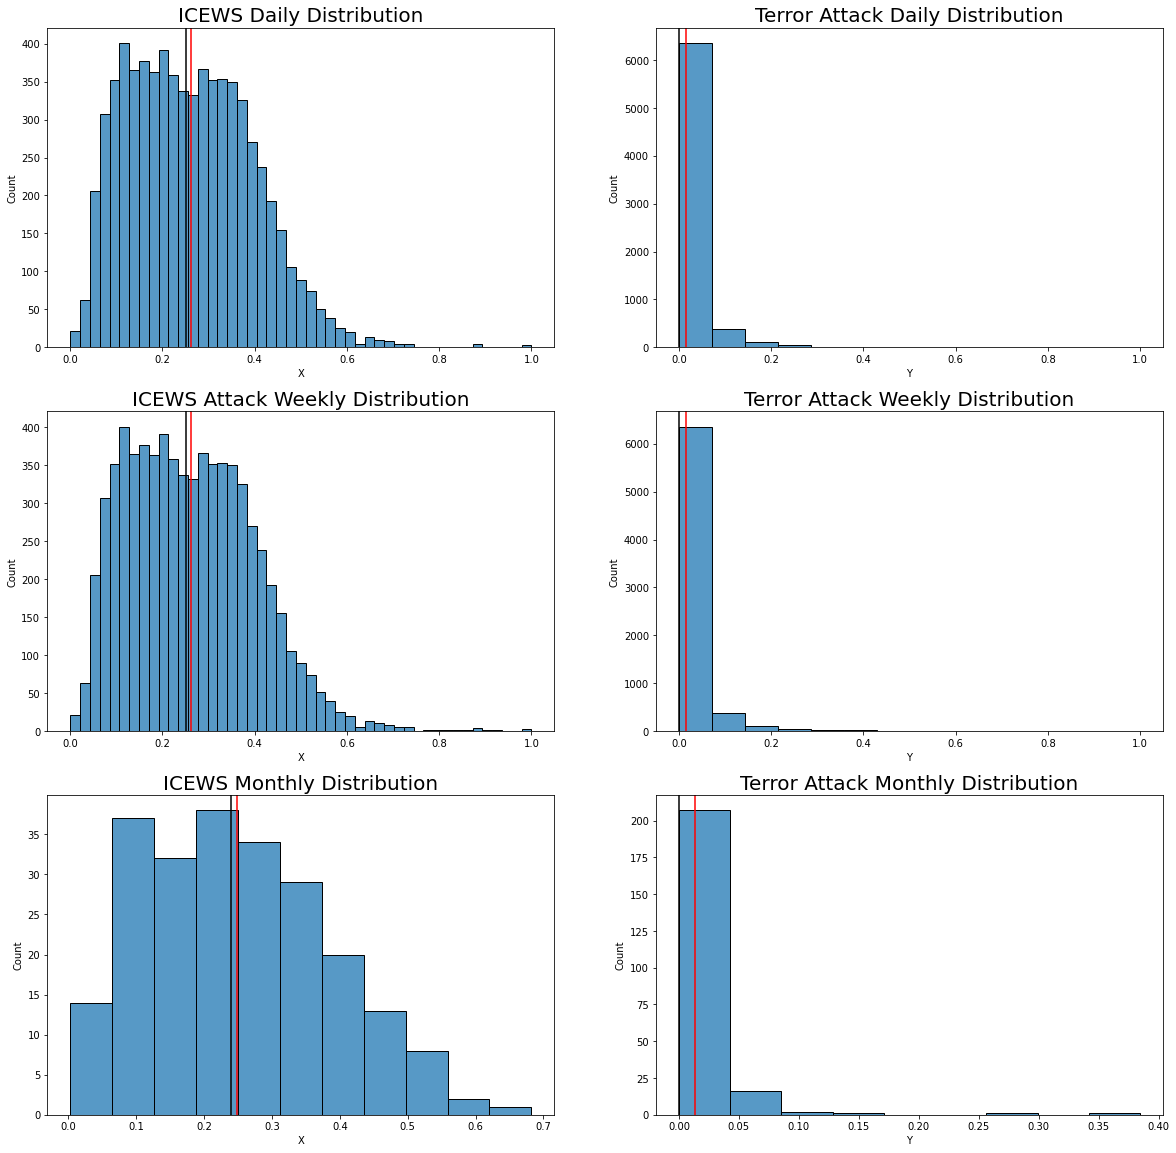

In [ ]:
# Visualize monthly, weekly, and daily distributions
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(20,20))

ax1.set_title('ICEWS Daily Distribution', fontsize=20)
sns.histplot(data=xd_count, ax=ax1)
ax1.axvline(x=xd_count.mean(), ymin=0, ymax=1, color='red')
ax1.axvline(x=xd_count.median(), ymin=0, ymax=1, color='black')

ax2.set_title('Terror Attack Daily Distribution', fontsize=20)
sns.histplot(data=yd_count, ax=ax2)
ax2.axvline(x=yd_count.mean(), ymin=0, ymax=1, color='red')
ax2.axvline(x=yd_count.median(), ymin=0, ymax=1, color='black')

ax3.set_title('ICEWS Attack Weekly Distribution', fontsize=20)
sns.histplot(data=xd_count, ax=ax3)
ax3.axvline(x=xd_count.mean(), ymin=0, ymax=1, color='red')
ax3.axvline(x=xd_count.median(), ymin=0, ymax=1, color='black')

ax4.set_title('Terror Attack Weekly Distribution', fontsize=20)
sns.histplot(data=yd_count, ax=ax4)
ax4.axvline(x=yd_count.mean(), ymin=0, ymax=1, color='red')
ax4.axvline(x=yd_count.median(), ymin=0, ymax=1, color='black')

ax5.set_title('ICEWS Monthly Distribution', fontsize=20)
sns.histplot(data=xm_count, ax=ax5)
ax5.axvline(x=xm_count.mean(), ymin=0, ymax=1, color='red')
ax5.axvline(x=xm_count.median(), ymin=0, ymax=1, color='black')

ax6.set_title('Terror Attack Monthly Distribution', fontsize=20)
sns.histplot(data=ym_count, ax=ax6)
ax6.axvline(x=ym_count.mean(), ymin=0, ymax=1, color='red')
ax6.axvline(x=ym_count.median(), ymin=0, ymax=1, color='black')

plt.show()

### Initial Finding 2:
There is no global correlation between the two datasets. However, terror data is not normaly distributed. 

In [ ]:
# Create xy dfs
x30 = xd_count.shift(periods=30).rolling(min_periods=30, window=30).mean()
y30 = yd_count.shift(periods=30).rolling(min_periods=30, window=30).mean()

x7 = xd_count.shift(periods=7).rolling(min_periods=7, window=7).mean()
y7 = yd_count.shift(periods=7).rolling(min_periods=7, window=7).mean()

dxy = pd.concat([xd_count, yd_count], axis=1)
xy30 = pd.concat([x30, y30], axis=1)
wxy = pd.concat([xw_count, yw_count], axis=1)
mxy = pd.concat([xm_count, ym_count], axis=1)
xy7 = pd.concat([x7, y7], axis=1)

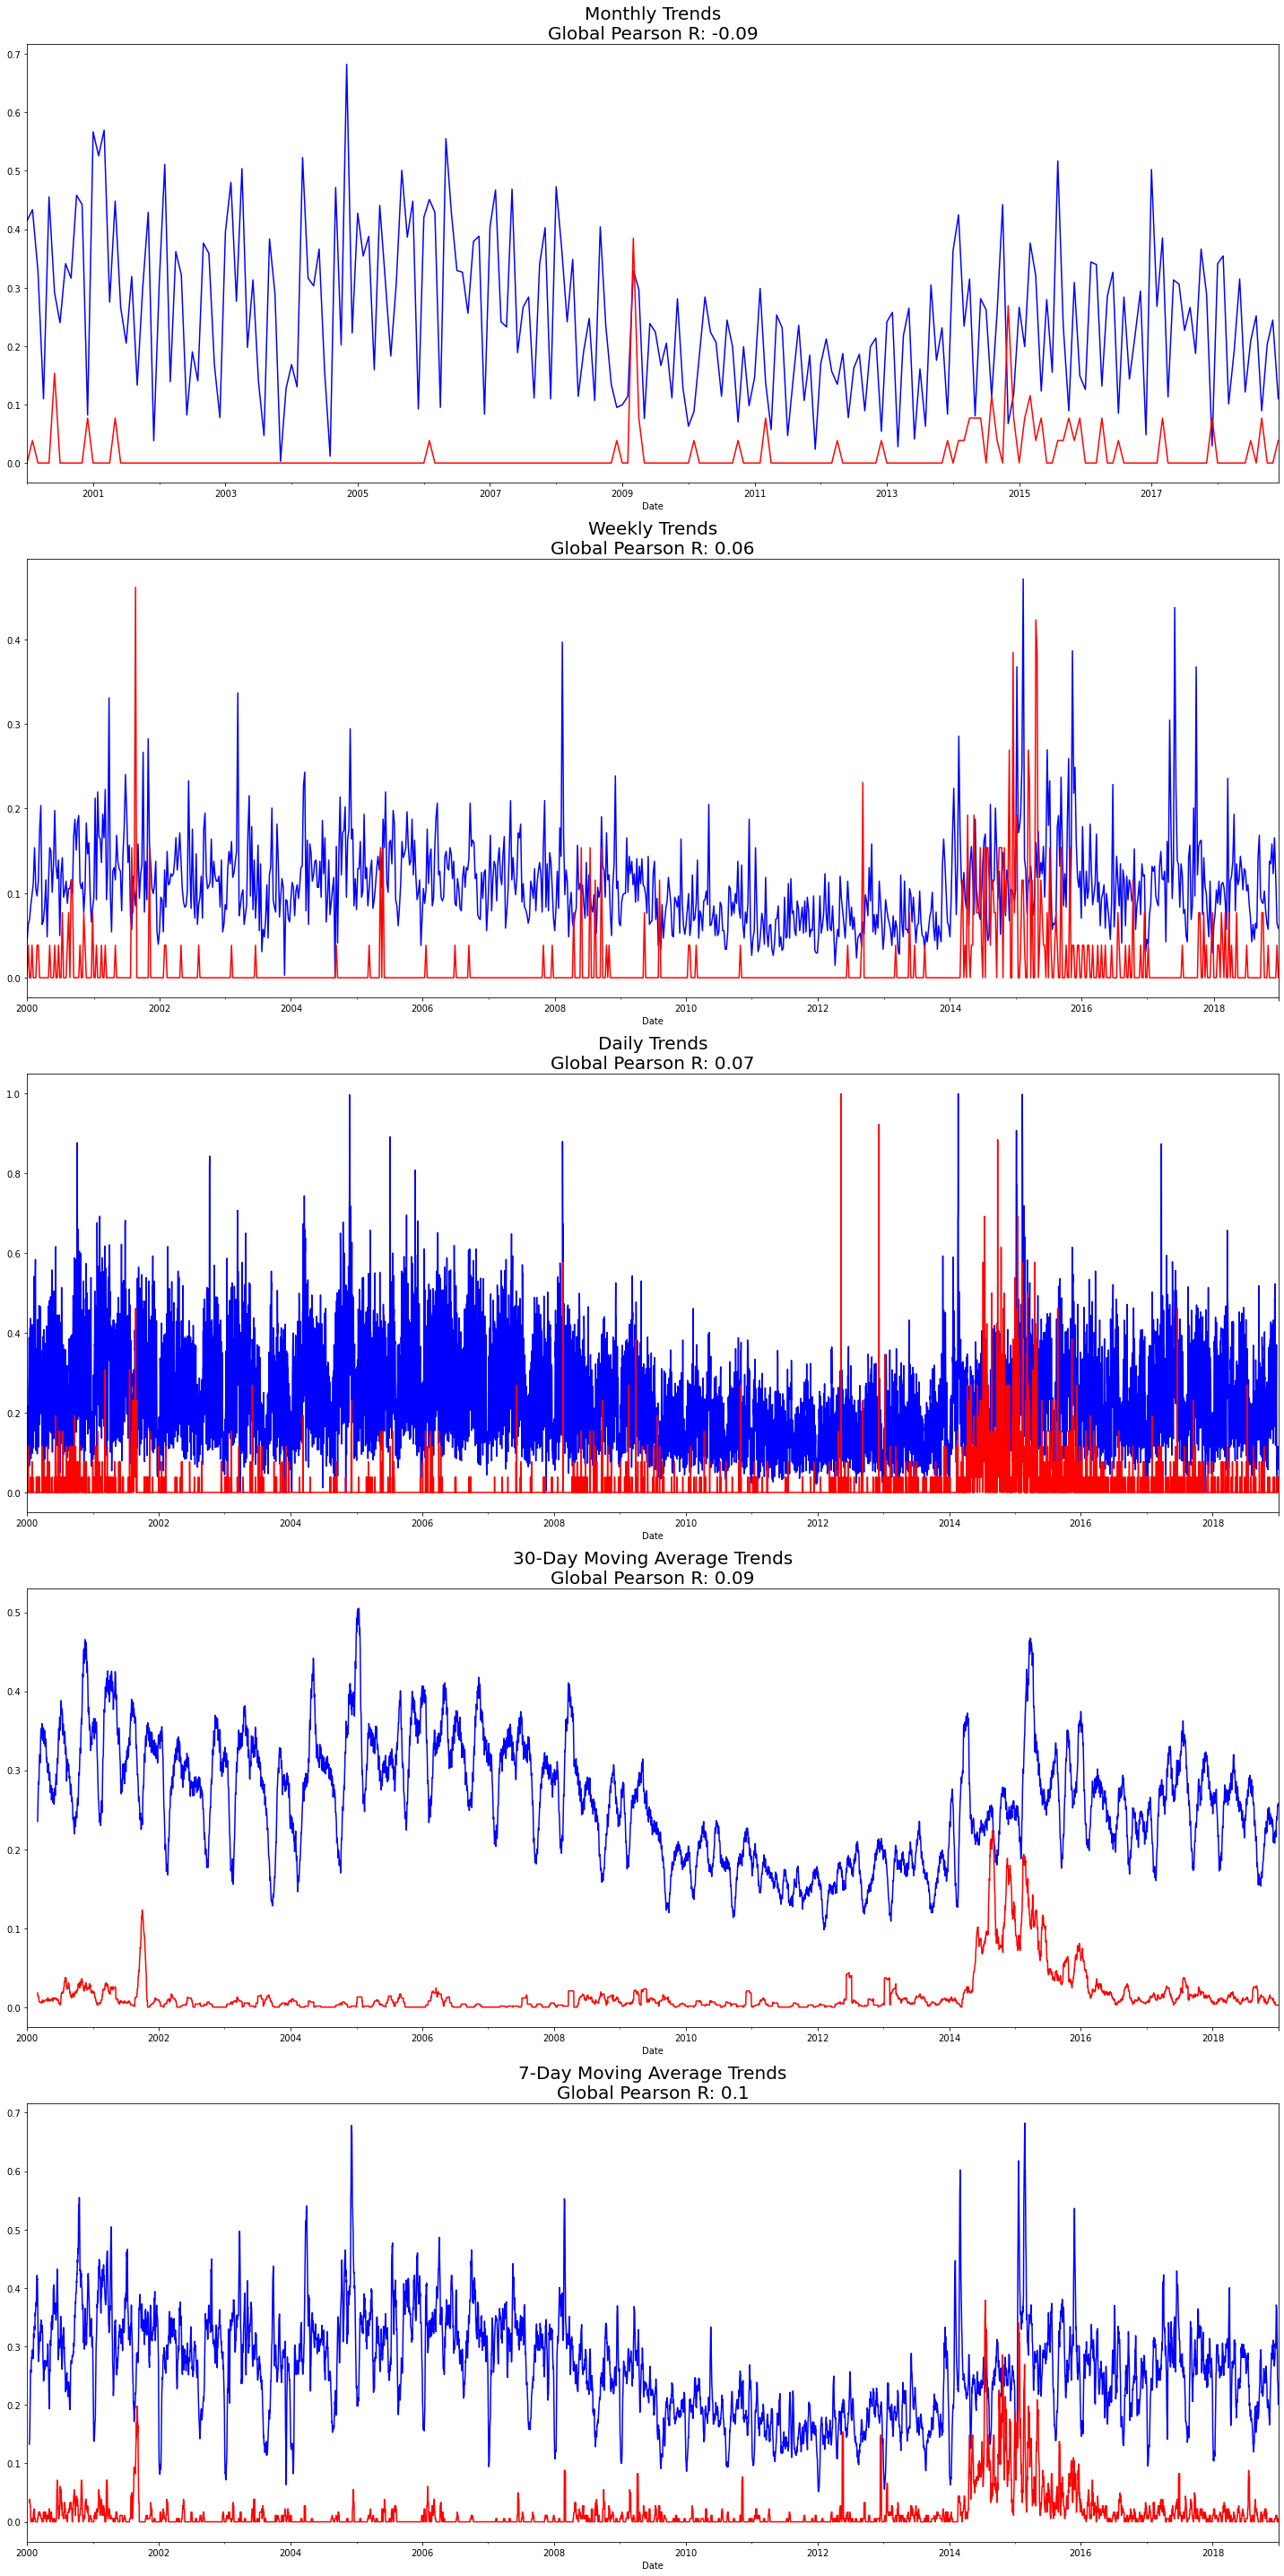

In [ ]:
# Visualize data monthly, weekly, daily, and 30-day moving average trends
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=5, ncols=1, figsize=(20,40))

ax1.set_title(f"Monthly Trends\nGlobal Pearson R: {round(mxy.corr()['X']['Y'],2)}", fontsize=20)
xm_count.plot(ax=ax1, color='blue')
ym_count.plot(ax=ax1, color='red')

ax2.set_title(f"Weekly Trends\nGlobal Pearson R: {round(wxy.corr()['X']['Y'],2)}", fontsize=20)
xw_count.plot(ax=ax2, color='blue')
yw_count.plot(ax=ax2, color='red')

ax3.set_title(f"Daily Trends\nGlobal Pearson R: {round(dxy.corr()['X']['Y'],2)}", fontsize=20)
xd_count.plot(ax=ax3, color='blue')
yd_count.plot(ax=ax3, color='red')

ax4.set_title(f"30-Day Moving Average Trends\nGlobal Pearson R: {round(xy30.corr()['X']['Y'],2)}", fontsize=20)
x30.plot(ax=ax4, color='blue')
y30.plot(ax=ax4, color='red')

ax5.set_title(f"7-Day Moving Average Trends\nGlobal Pearson R: {round(xy7.corr()['X']['Y'],2)}", fontsize=20)
x7.plot(ax=ax5, color='blue')
y7.plot(ax=ax5, color='red')

#path = os.path.join(root_dir, 'Visualizations/Global_Person_R.jpg')

#plt.savefig(path, dpi=800, facecolor='w', edgecolor='b',
#            transparent=False, bbox_inches=None, pad_inches=0.1)

plt.tight_layout()
plt.show()

## Now lets look at a rolling Pearson R

### Initial Finding 3:
There is an almost even split between pos/neg correlation, but moving 30-day avg. with a 30-day correlation window appears to offer the best results.

In [ ]:
# Rolling window
n=30

# Creating rolling Pearson Rs
d_rolling = dxy['X'].rolling(window=n, center=True).corr(dxy['Y'])
w_rolling = wxy['X'].rolling(window=n, center=True).corr(wxy['Y'])
m_rolling = mxy['X'].rolling(window=n, center=True).corr(mxy['Y'])
roll30 = xy30['X'].rolling(window=n, center=True).corr(xy30['Y'])
roll7 = xy7['X'].rolling(window=n, center=True).corr(xy7['Y'])

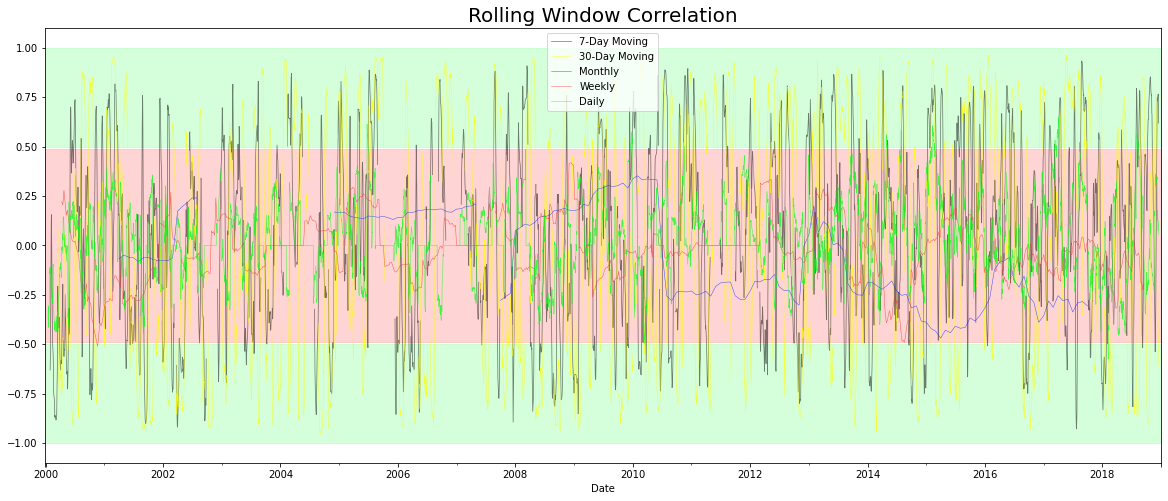

In [ ]:
# Visualize data monthly, weekly, daily, and 30-day moving average trends
fig, ax = plt.subplots(figsize=(20,8))

ax.set_title("Rolling Window Correlation", fontsize=20)
roll7.replace([np.inf, -np.inf], 0).plot(ax=ax, color='black', alpha=.5, label='7-Day Moving', linewidth=.75)
roll30.replace([np.inf, -np.inf], 0).plot(ax=ax, color='#ffff00', label='30-Day Moving', linewidth=.5, alpha=.75)
m_rolling.replace([np.inf, -np.inf], 0).plot(ax=ax, color='#0026ff', label='Monthly', linewidth=.5, alpha=.75)
w_rolling.replace([np.inf, -np.inf], 0).plot(ax=ax, color='#f23030', label='Weekly', linewidth=.5, alpha=.75)
d_rolling.replace([np.inf, -np.inf], 0).plot(ax=ax, color='#00ff11', label='Daily', linewidth=.5, alpha=.75)
ax.axhspan(-.49, .49, color="#ffabab", alpha=.5)
ax.axhspan(-.5, -1.00, color="#abffb6", alpha=.5)
ax.axhspan(.5, 1.00, color="#abffb6", alpha=.5)

plt.legend()
plt.show()

In [ ]:
r30 = roll30.replace([np.inf, -np.inf], 0).dropna()
r30 = r30.loc[(r30 > .49) | (r30 < -.49)]

rd = d_rolling.replace([np.inf, -np.inf], 0).dropna()
rd = rd.loc[(rd > .49) | (rd < -.49)]

rw = w_rolling.replace([np.inf, -np.inf], 0).dropna()
rw = rw.loc[(rw > .49) | (rw < -.49)]

rm = m_rolling.replace([np.inf, -np.inf], 0).dropna()
rm = rm.loc[(rm > .49) | (rm < -.49)]

r7 = roll7.replace([np.inf, -np.inf], 0).dropna()
r7 = r7.loc[(r7 > .49) | (r7 < -.49)]

In [ ]:
print(f"Rolling 30: {round(len(r30.index) / len(roll30.index),2)}")
print(f"Monthly: {round(len(rm.index) / len(m_rolling.index),2)}")
print(f"Daily: {round(len(rd.index) / len(d_rolling.index),2)}")
print(f"Weekly: {round(len(rw.index) / len(w_rolling.index),2)}")
print(f"Rolling 7: {round(len(r7.index) / len(roll7.index),2)}")

Rolling 30: 0.53
Monthly: 0.0
Daily: 0.01
Weekly: 0.0
Rolling 7: 0.31


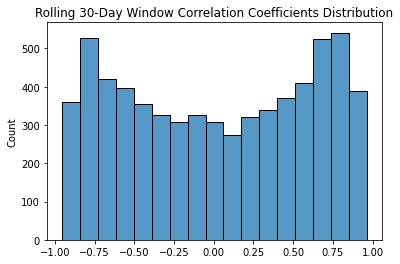

In [ ]:
plt.title('Rolling 30-Day Window Correlation Coefficients Distribution')
sns.histplot(roll30.replace([np.inf, -np.inf], np.nan).dropna())
#plt.axvline(x=roll30.mean(), color='red')
#plt.axvline(x=roll30.median(), color='green')
plt.show()

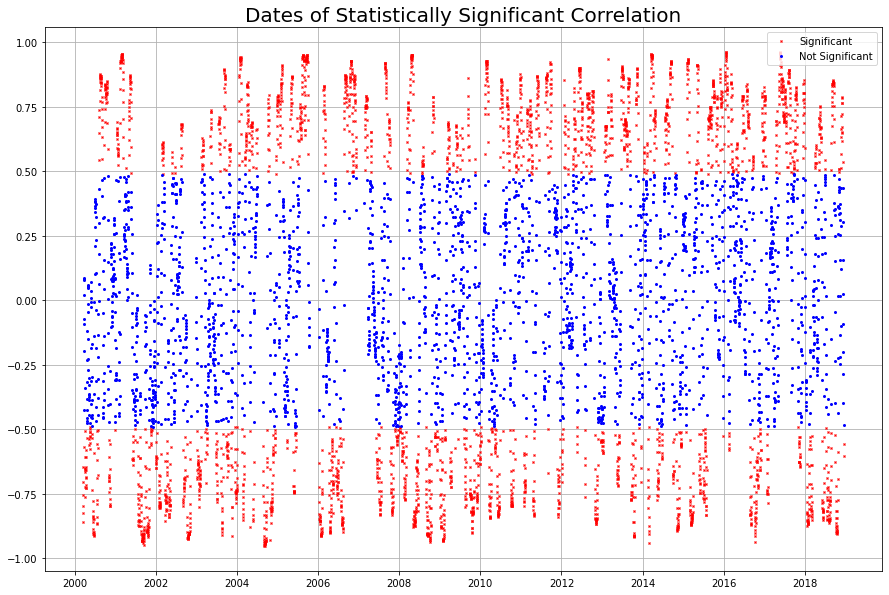

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
ax.set_title('Dates of Statistically Significant Correlation', fontsize=20)
ax.grid()
ax.plot(r30.index, r30, linestyle='', marker='x', markersize=2, color='red', label='Significant')
ax.plot(roll30.loc[~roll30.isin(r30)].index, roll30.loc[~roll30.isin(r30)], linestyle='', 
        marker='o', markersize=2, color='blue', label='Not Significant')
plt.legend(loc='upper right')
plt.show()

## Filter ICEWS

In [ ]:
x1 = x.loc[(x['Event Text'].str.contains('Occupy|change|force|protest|demonstrate')) & 
          (~x['Event Text'].str.contains('intent|Accede|Obstruct|non-force|Demobilize'))]
x1_count = pd.Series((((x1.groupby('Date')['X'].count() -
                        x1.groupby('Date')['X'].count().min()) / 
                       (x1.groupby('Date')['X'].count().max() - 
                        x1.groupby('Date')['X'].count().min())) * 1)).sort_index(ascending=True).asfreq('D').fillna(0)

In [ ]:
xy1 = pd.concat([x1_count, yd_count], axis=1)

In [ ]:
# Rolling window
n=10

# Creating rolling Pearson Rs
r1 = xy1['X'].rolling(window=n, center=True).corr(xy1['Y'])

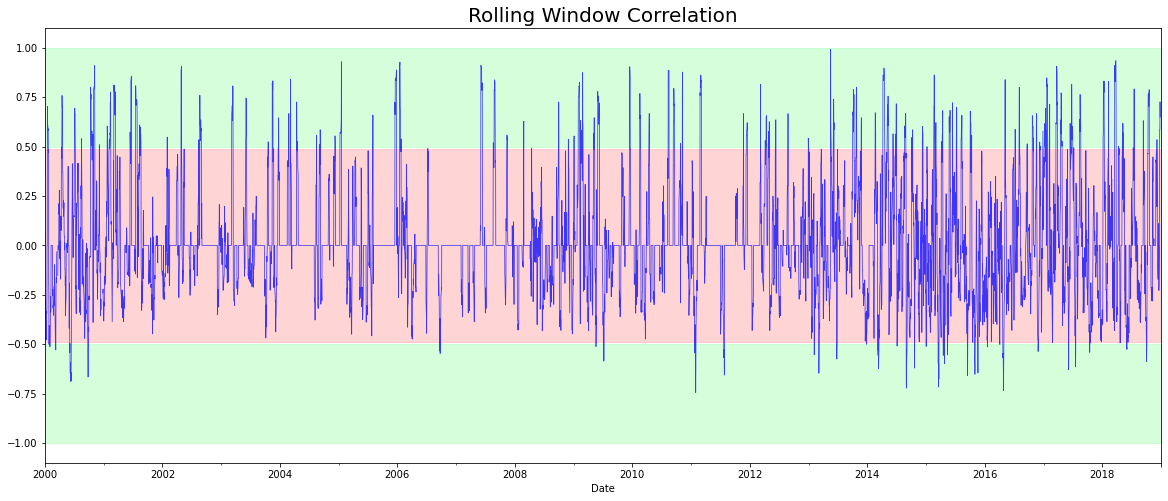

In [ ]:
# Visualize data monthly, weekly, daily, and 30-day moving average trends
fig, ax = plt.subplots(figsize=(20,8))

ax.set_title("Rolling Window Correlation", fontsize=20)
r1.replace([np.inf, -np.inf], 0).plot(ax=ax, color='blue', alpha=.75, linewidth=.75)
ax.axhspan(-.49, .49, color="#ffabab", alpha=.5)
ax.axhspan(-.5, -1.00, color="#abffb6", alpha=.5)
ax.axhspan(.5, 1.00, color="#abffb6", alpha=.5)

#plt.legend()
plt.show()

In [ ]:
#r1a = r1.replace([np.inf, -np.inf], 0).dropna()
#r1a = r1a.loc[(r30 > .49) | (r30 < -.49)]

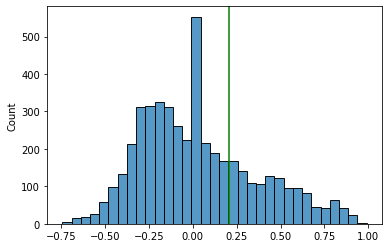

In [ ]:
sns.histplot(r1.replace([np.inf, -np.inf], np.nan).dropna())
plt.axvline(x=r1.mean(), color='red')
plt.axvline(x=r1.median(), color='green')
plt.show()

In [ ]:
x['Source Sectors'].isnull()

27         True
30         True
59         True
63        False
64        False
          ...  
741757    False
741782    False
741783    False
741787    False
741788    False
Name: Source Sectors, Length: 1243819, dtype: bool

## MISC

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score

In [ ]:
x1 = x.loc[(x['Event Text'].str.contains('Occupy|change|force|protest|demonstrate')) & 
          (~x['Event Text'].str.contains('intent|Accede|Obstruct|non-force|Demobilize'))]
x1_count = pd.Series((((x1.groupby('Date')['E Count'].count() -
                        x1.groupby('Date')['E Count'].count().min()) / 
                       (x1.groupby('Date')['E Count'].count().max() - 
                        x1.groupby('Date')['E Count'].count().min())) * 1)).sort_index(ascending=True).asfreq('D').fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
x1_count.shift(periods=30).rolling(min_periods=30, window=30).mean().plot(ax=ax)
yd_count.plot(ax=ax, color='red', alpha=.5)

In [ ]:
n = 10
xd_roll = xd_count.shift(periods=n).rolling(min_periods=n, window=n).mean()
y_roll = yd_count.shift(periods=n).rolling(min_periods=n, window=n).mean()

In [ ]:
pd.concat([xd_roll, y_roll], axis=1).corr()

In [ ]:
data = pd.concat([xd_roll, y_roll], axis=1)

In [ ]:
data.dropna(how='any', axis=0, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data['E Count'], data['T Count'], test_size=.3, random_state=1)

In [ ]:
x_train = np.array(x_train).reshape(-1,1)
x_test = np.array(x_test).reshape(-1,1)

In [ ]:
scale = RobustScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [ ]:
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)

In [ ]:
r2_score(y_test, pred)

In [ ]:
plt.scatter(x_test, y_test)
plt.plot(x_test, pred, color='red')

In [ ]:
pd.concat([xd_roll, y_roll], axis=1).plot(kind='scatter', x='E Count', y='T Count')

In [ ]:
pd.concat([x1_roll, y_roll], axis=1).plot(kind='scatter', x='E Count', y='T Count')

In [ ]:
# Filter by Citizen-Gov/Ideo/Rel/Soc issues
x = events.loc[(events['Source Name'].str.contains('Citizen')) & 
               (events['Target Sectors'].str.contains('Government|Ideological|Religious|Social', case=False, na=False))]

x_count = pd.Series((((x.groupby('Date')['Event Count'].count() - 
                       x.groupby('Date')['Event Count'].count().min()) / 
                      (x.groupby('Date')['Event Count'].count().max() - 
                       x.groupby('Date')['Event Count'].count().min())) * 1)).sort_index(ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
x_count.plot(ax=ax, alpha=.75)
terr_count.plot(ax=ax, color='red', alpha=.5)

In [ ]:
cg_peak, _ = find_peaks(cg_count.rolling(30, win_type='triang').mean().ravel())
cg_count[cg_peak]

In [ ]:
t_peak, _ = find_peaks(terr_count.ravel())
terr_count[t_peak]

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.scatter(cg_peak, cg_count.rolling(30, win_type='triang').mean().ravel()[cg_peak])
#ax.plot(terr_count.ravel())

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('30-Day Rolling Average Cit-Gov Publications and Terr Attacks')
terr_count.plot(ax=ax, color='#d43535', alpha=.75, kind='area', grid=True, legend=True)
cg_count.rolling(30).mean().fillna(0).plot(ax=ax, kind='area', grid=True, color='#75ff83', legend=True)
plt.show()

In [ ]:
cg_events['Event Text'].unique()

In [ ]:
cg_events_2 = cg_events.loc[~cg_events['Event Text'].str.contains('suicide|emphathetic|intent to engage|appeal for diplomatic|appeal for intell|Acknowledge or claim responsibility|Express intent to meet|Consider policy|Reduce relations|Make optimistic comment|Abduct, hijack|Express intent to cooperate|Provide aid|Express intent|Appeal for economic|Appeal for easing of admin|Engage in diplomatic|Praise or endorse|assault|break relations|Impose embargo|stop economic|Yield|formal agreement|Consult|Make a Visit|Express accord|Defy norms|release person|intelligence|cooperate')]

In [ ]:
cg_events_2['Event Text'].unique()

In [ ]:
cg_events_2 = cg_events_2.loc[~cg_events_2['Event Text'].str.contains('Cooperate|Appeal|economic aid|Expel or withdraw|Ease military|Grant|Recieve|Retreat|Return, release property')]

In [ ]:
cg_count_2 = pd.Series((((cg_events_2.groupby('Date')['Event Count'].count() - 
                        cg_events_2.groupby('Date')['Event Count'].count().min()) / 
                       (cg_events_2.groupby('Date')['Event Count'].count().max() - 
                        cg_events_2.groupby('Date')['Event Count'].count().min())) * 1)).sort_index(ascending=True)

In [ ]:
cg_count_2 = cg_count_2.asfreq('D').fillna(0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
ax.set_title('Peak Citizen-Gov Dissent Publications and 30-Day Rolling Average Terror Attacks')
terr_count.plot(ax=ax, color='#d43535', alpha=.75, grid=True, legend=True)
cg_count_2.rolling(30).mean().plot(ax=ax, kind='area', grid=True, color='#75ff83', legend=True)
plt.show()

In [ ]:
terror.groupby(['iyear', 'imonth'])['Terrorism Count'].count().plot()

In [ ]:
events.groupby(['Year', 'Month'])['Event Count'].count().plot()

In [ ]:
events['Event Text'].unique()

In [ ]:
events.loc[(events['Event Text'].str.contains('Occupy|change|force|protest|demonstrate')) & 
           (~events['Event Text'].str.contains('intent|Accede|Obstruct|non-force|Demobilize'))]['Event Text'].unique()

In [ ]:
x = events.loc[(events['Event Text'].str.contains('Occupy|change|force|protest|demonstrate')) & 
               (~events['Event Text'].str.contains('intent|Accede|Obstruct|non-force|Demobilize'))]
x_count = pd.Series((((x.groupby('Date')['Event Count'].count() - 
                        x.groupby('Date')['Event Count'].count().min()) / 
                       (x.groupby('Date')['Event Count'].count().max() - 
                        x.groupby('Date')['Event Count'].count().min())) * 1)).sort_index(ascending=True)

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title('ICEWS 30-Day Moving Average, and Terror Attacks 5-Day Moving Average')

#ax.axvspan(date2num(datetime(2001,2,14)), date2num(datetime(2001,2,14)), label="Kosovo Bus Bombing",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2004,4,11)), date2num(datetime(2004,4,11)), label="Madrid Train Bombing",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2005,7,7)), date2num(datetime(2005,7,7)), label="London Bombings",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2011,4,11)), date2num(datetime(2011,4,11)), label="Minsk Metro Bombing",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2011,6,22)), date2num(datetime(2011,6,22)), label="Norway Attacks",color="#66baff")
ax.axvspan(date2num(datetime(2014,2,20)), date2num(datetime(2016,1,1)), label="Russian Invasion of Ukraine",color="#5ea3f7", alpha=.75)
#ax.axvspan(date2num(datetime(2014,7,17)), date2num(datetime(2014,7,17)), label="Malaysia Airlines Flight 17",color="black")
#ax.axvspan(date2num(datetime(2015,1,7)), date2num(datetime(2015,1,9)), label="Ile-de-France Attacks",color="black")
#ax.axvspan(date2num(datetime(2015,1,13)), date2num(datetime(2015,1,13)), label="Volnovakha Bus Attack",color="black")
#ax.axvspan(date2num(datetime(2015,11,13)), date2num(datetime(2015,11,13)), label="Paris Attack",color="black")
#ax.axvspan(date2num(datetime(2016,3,22)), date2num(datetime(2016,3,22)), label="Brussels Bombing",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2016,6,14)), date2num(datetime(2016,6,14)), label="Nice Truck Attack",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2016,12,19)), date2num(datetime(2016,12,19)), label="Berlin Christmas Market Attack",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2017,3,22)), date2num(datetime(2017,3,22)), label="Westminster Attack",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2017,5,22)), date2num(datetime(2017,5,22)), label="Manchester Arena Bombings",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2017,6,3)), date2num(datetime(2017,6,3)), label="London Bridge Attack",color="#5ea3f7")
#ax.axvspan(date2num(datetime(2017,8,17)), date2num(datetime(2017,8,18)), label="Barcelona Attack",color="#5ea3f7")

terr_count.rolling(5).mean().plot(ax=ax, color='#d43535', kind='line', legend=True, grid=True)
x_count.rolling(30).mean().plot(ax=ax, color='#75ff83', legend=True, grid=True)
plt.legend()

plt.show()

In [ ]:
t_peak, _ = find_peaks(terr_count, prominence=.1)
x_peak, _ = find_peaks(x_count, prominence=.1)

In [ ]:
x_count[x_peak]

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.set_title('Peaks', fontsize=25)
ax.plot(t_peak, terr_count[t_peak], linestyle='', marker='o', markersize=4)
ax.plot(x_peak, x_count[x_peak], linestyle='', marker='x', markersize=5)
plt.show()

In [ ]:
print(t_peak.size, x_peak.size)

In [ ]:
x_peak = np.resize(x_peak, t_peak.size)

In [ ]:
m, b = np.polyfit(x_count[x_peak], terr_count[t_peak], 1)

corr_matrix = np.corrcoef(x_count[x_peak], terr_count[t_peak])
xy_corr = corr_matrix[0,1]
r2 = xy_corr**2

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.set_title('Relationship Between ICEWS/Terror Attacks Peaks Between 2000 and 2018', fontsize=20)
#ax.text(x=-75, y=6250, 
 #       s=f"R2: {round(r2, 2)}\nCorrelation {round(xy_corr, 2)}", 
  #      fontsize=20, fontstyle='italic', fontvariant='small-caps', bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))
ax.scatter(x_count[x_peak], terr_count[t_peak])
ax.plot(x_count[x_peak], m*x_count[x_peak]+b, color='red')

plt.show()

In [ ]:
coef = np.polyfit(x_peak, t_peak, 3)

poly = np.poly1d(coef)
new_x = np.linspace(x_peak[0], x_peak[-1])
new_y = poly(new_x)

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))

ax.set_title('Relationship Between ICEWS/Terror Attacks Peaks Between 2000 and 2018', fontsize=15)
ax.text(x=-75, y=6500, s=f"R2: {round(r2_score(t_peak, poly(x_peak)),2)}",
       fontsize=20, fontstyle='italic', fontvariant='small-caps', bbox=dict(facecolor='none', edgecolor='green', boxstyle='round'))
ax.plot(x_peak, t_peak, 'o')
ax.plot(new_x, new_y, color='red')

plt.show()